In [2]:
! pip install PyPDF2

     -------------------------------------- 232.6/232.6 kB 2.9 MB/s eta 0:00:00


In [22]:
#### MAIN IMPORT SECTION  #####

from PyPDF2 import PdfReader
import io
import numpy as np
import random

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
import pandas as pd


In [23]:
### DEFINING A FUNCTION TO INIT THE MAIN GLOBAL VARIABLES OF THE TASK

text = None
char_indices = None
indices_char = None
chars = None
# chunk length
maxlen = None 
step = None
sentences = None
next_chars = None

def init_work_env(additional_chars=None):
    
    ### READING FILE
    print('opening file...')
    path = 'divina_commedia.txt'
    global text
    with io.open(path, encoding='utf-8') as f:
        text = f.read().lower()
    print('text length:', len(text))
    print()
    print('\n\n\n\n\n', '****** first 1000 characters *******', '\n\n\n\n')
    text[0:1000]
    
    
    # CREATING Unique characters list
    global chars
    chars = sorted(list(set(text)))
    print('total chars: ', len(chars))
    
    # Added section to handle additional_chars from external sources
    if additional_chars:
        print("Extending vocabulary")
        chars.extend(sorted(additional_chars))
        print('extendend total chars: ', len(chars))

    # Creating vocabularies
    global char_indices
    global indices_char
    char_indices = dict((c, i) for i, c in enumerate(chars))
    indices_char = dict((i, c) for i, c in enumerate(chars))

    print(char_indices)
    print(indices_char)
    
    global maxlen
    global step
    global sentences
    global next_chars
    # chunk length
    maxlen = 30 
    step = 3
    sentences = []
    next_chars = []
    for i in range(0, len(text) - maxlen, step):
        sentences.append(text[i: i + maxlen])
        next_chars.append(text[i + maxlen])
    print('number of sequences: ', len(sentences))
    print(sentences[11])
    print(next_chars[11])
    
init_work_env()

opening file...
text length: 558240






 ****** first 1000 characters ******* 




total chars:  40
{'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, ':': 10, ';': 11, '<': 12, '>': 13, '?': 14, '`': 15, 'a': 16, 'b': 17, 'c': 18, 'd': 19, 'e': 20, 'f': 21, 'g': 22, 'h': 23, 'i': 24, 'j': 25, 'l': 26, 'm': 27, 'n': 28, 'o': 29, 'p': 30, 'q': 31, 'r': 32, 's': 33, 't': 34, 'u': 35, 'v': 36, 'x': 37, 'y': 38, 'z': 39}
{0: '\n', 1: ' ', 2: '!', 3: '"', 4: "'", 5: '(', 6: ')', 7: ',', 8: '-', 9: '.', 10: ':', 11: ';', 12: '<', 13: '>', 14: '?', 15: '`', 16: 'a', 17: 'b', 18: 'c', 19: 'd', 20: 'e', 21: 'f', 22: 'g', 23: 'h', 24: 'i', 25: 'j', 26: 'l', 27: 'm', 28: 'n', 29: 'o', 30: 'p', 31: 'q', 32: 'r', 33: 's', 34: 't', 35: 'u', 36: 'v', 37: 'x', 38: 'y', 39: 'z'}
number of sequences:  186070
 mezzo del cammin di nostra vi
t


### Simple Explanation about how sentences are converted into tensors 

In [5]:
# input (x) and output (y) tensors to train the RNN model
# one-hot encoding the sequences of text (sentences) and their target characters (next_chars)

print('generating input and output...')

### TENSORS INIT:

# Input Tensor x = (number of sequences, sequence length, number of unique characters)
### So each sequnce (row) is a matrix where every character in the sequnce is one-hot encoded
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)

# Output Tensor y = (number of sequences X number of unique characters)
### The output is the one-hot encoded next character corresponding to each input sequence
y = np.zeros((len(sentences), len(chars)), dtype=bool)

# Iterates over each sentence in the list of chunks
for i, sentence in enumerate(sentences):
    
    # Iterates over each char of the chunk/sentence
    for t, char in enumerate(sentence):
        
        # chunk X char position in chunk X char index in vocabulary
        x[i, t, char_indices[char]] = 1
        
        #### EXAMPLE INPUT TENSOR ###
        # chars = ['a', 'b', 'c']
        # vocabulary = {'a': 0, 'b': 1, 'c': 2}
        # chunk = "abc"
        ### So the first matrix of the tensor will be x[0]:
        #  [
        #    [1, 0, 0],  # char "a" row
        #    [0, 1, 0],  # char "b" row
        #    [0, 0, 1]   # char "c" row
        #  ]
        
        
    # Contains the next char for each chunk in sentences
    # es: sentences = [abc, def, ...]
        # So for y[0] that is related to chunk "abc" we will have:
        
        # [0, 0, 0, 1, 0, ..., 0],  # row for chunk "abc", activated column "d"
    y[i, char_indices[next_chars[i]]] = 1

print(x.shape)
print(y.shape)

generating input and output...
(186070, 30, 40)
(186070, 40)


### MODEL TEMPLATE (STARTING POINT)

In [24]:
model = Sequential()

# input_shape is related to the dimensions of each single instance (chunk lenght X number of unique chars)
model.add(LSTM(128, input_shape=(maxlen, len(chars))))

model.add(Dense(len(chars), activation='softmax'))

### Root Mean Square Propagation optimizer 
    # is an adaptive gradient-based optimization algorithm
    # well-suited for RNNs like LSTMs because it adjusts the learning rate for each parameter dynamically, 
    # helping stabilize training in the presence of exploding or vanishing gradients
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)


model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 128)               86528     
                                                                 
 dense_12 (Dense)            (None, 40)                5160      
                                                                 
Total params: 91688 (358.16 KB)
Trainable params: 91688 (358.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Function: `reconstruct_text_from_test_x`

This function reconstructs text sequences from one-hot encoded input data.

#### **Description**
The function takes a set of one-hot encoded input sequences (`test_x`) and a mapping dictionary (`indices_char`) to convert each sequence back into its original text format.

#### **Arguments**
- `test_x`: A NumPy array of shape `(num_sequences, maxlen, num_chars)` containing one-hot encoded sequences.
- `indices_char`: A dictionary mapping indices (integers) to corresponding characters (e.g., `{0: 'a', 1: 'b', ...}`).

#### **Returns**
- `reconstructed_texts`: A list of strings, where each string is a reconstructed text sequence derived from the one-hot encoded data.



In [ ]:
# Some comments about how this callback method works

import sys
def testAfterEpoch(epoch, _):
  print()
  print()
  print('******* Epoch: %d ********' % (epoch+1))
  start_index = random.randint(0, len(text)-maxlen-1)

  # INIT GENERATED
  generated = ''
  sentence = text[start_index :  start_index + maxlen]
  generated = generated + sentence

  print('***** starting sentence *****')
  print(sentence)
  print('*****************************')
  sys.stdout.write(generated)
    
  # Make 400 predictions
  for i in range(400):
    # Creating input instance (a tensor with only one instance matrix of char position in chunk X char index in vocabulary)
    x_pred = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
      x_pred[0, t, char_indices[char]] = 1
    
    # inference
    preds = model.predict(x_pred, verbose=0)[0]
    # getting max prob class
    next_index = np.argmax(preds)
    # from indeces --> to char
    next_char = indices_char[next_index]
    
    # Removing the oldest character sentence[0]
    # Appending the next_char at the end of the updated sentence
    sentence = sentence[1:] + next_char
    
    # Print without newline so each new char will be appended to the generated string at each loop
    sys.stdout.write(next_char)
    #ensures the output is immediately displayed
    sys.stdout.flush()
  
  print()


In [17]:
print_callback = LambdaCallback(on_epoch_end=testAfterEpoch)

In [20]:
model.fit(x, y,
          batch_size = 2048,
          epochs = 20,
          callbacks = [print_callback])

Epoch 1/20

91/91 [==============================] - ETA: 0s - loss: 2.6481

******* Epoch: 1 ********
***** starting sentence *****
gia` volta.

e quale ismeno gi
*****************************
gia` volta.

e quale ismeno gia che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che ser che se
91/91 [==============================] - 40s 432ms/step - loss: 2.6481
Epoch 2/20
91/91 [==============================] - ETA: 0s - loss: 2.0550

******* Epoch: 2 ********
***** starting sentence *****
el loco
  dove si truova pria 
*****************************
el loco
  dove si truova pria che se se se se se se se se se se se se se se se se se se se se se se se se se se

In [17]:
# borrowed function to easily plot training and validation accuracy
# Made metric dynamic
def plot_performance(history, metric="accuracy"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.tight_layout()

    train_acc = history.history[metric]
    train_loss = history.history['loss']
    val_acc = history.history[f'val_{metric}']
    val_loss = history.history['val_loss']

    # Plot loss
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss')
    ax[0].plot(train_loss, label='Training Loss')
    ax[0].plot(val_loss, label='Validation Loss')
    ax[0].legend()

    # Plot accuracy
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel(metric)
    ax[1].set_title(metric)
    ax[1].plot(train_acc, label=f'Training {metric}')
    ax[1].plot(val_acc, label=f'Validation {metric}')
    ax[1].legend()

    plt.show()


## Splitting data for test and validation

### Function Documentation: `splitting_udf`

Custom function, which is designed to process text data, split it into training, validation, and test datasets, and encode it into tensors suitable for training sequence models like LSTMs or GRUs.

#### Function Overview
The `splitting_udf` function:
1. Splits input text into three subsets: training, validation, and testing.
2. Creates sequences of fixed length (`maxlen`) from the text data and their corresponding labels.
3. Converts these sequences into one-hot encoded tensors for input and output.

#### Parameters
- **`text`**: A string containing the input data.
- **`maxlen`**: The fixed length of sequences to be generated.
- **`step`**: The step size for sliding the window over the text when generating sequences (default: 3).
- **`train_perc`**: The percentage of text allocated to the training set (default: 0.7).
- **`val_perc`**: The percentage of text allocated to the validation set (default: 0.15). The remainder is used for testing.

#### Steps
1. **Split the text**:
   The function slices the input `text` into training, validation, and test sets based on the provided percentages.

2. **Generate sequences**:
   - Each subset is processed to generate overlapping sequences of length `maxlen` (input) and their subsequent characters (labels).
   - Example:
     - Input sequence: `"ABCDEF"` with `maxlen=3`
     - Sentences: `["ABC", "DEF"]`
     - Labels: `["D", "G"]`

3. **One-hot encoding**:
   - Sentences and labels are converted to one-hot encoded tensors based on the unique characters in the text.
   - Example:
     - Characters: `['A', 'B', 'C', 'D']`
     - Sentence: `"ABC"`
     - One-hot encoded tensor:
       ```
       [[[1, 0, 0, 0],  # 'A'
         [0, 1, 0, 0],  # 'B'
         [0, 0, 1, 0]]] # 'C'
       ```

In [25]:
# Creating User Defined Function to easily handle dataframe splitting and tensor encoding

def splitting_udf(text, maxlen, step=3, train_perc=0.7, val_perc=0.15):

    # Defining training, validationa and test shapes  0.7, 0.15, 0.15
    train_size = int(len(text) * train_perc)
    val_size = int(len(text) * val_perc)

    # Slicing text into train, validation, and test:
    train_text = text[:train_size]
    val_text = text[train_size:train_size + val_size]
    test_text = text[train_size + val_size:]

    def generate_sequences(text, maxlen, step):
        sentences = []
        next_chars = []

        # iterate over the text 
        for i in range(0, len(text) - maxlen, step):


            # append chunks of lenght maxlen: ABC, DEF,GHI ...  ---> INPUT
            sentences.append(text[i: i + maxlen])

            # append the next chunk of the lenght: D, G, ...    ---> LABEL 
            next_chars.append(text[i + maxlen])
        return sentences, next_chars

    # Generate sequences for training, validation, and test
    train_sentences, train_next_chars = generate_sequences(train_text, maxlen, step)
    val_sentences, val_next_chars = generate_sequences(val_text, maxlen, step)
    test_sentences, test_next_chars = generate_sequences(test_text, maxlen, step)

    # Convert to one-hot encoded arrays (as describe above)
    def vectorize(sentences, next_chars, char_indices, maxlen, num_chars):
        x = np.zeros((len(sentences), maxlen, num_chars), dtype=bool)
        y = np.zeros((len(sentences), num_chars), dtype=bool)
        for i, sentence in enumerate(sentences):
            for t, char in enumerate(sentence):
                x[i, t, char_indices[char]] = 1
            y[i, char_indices[next_chars[i]]] = 1
        return x, y

    # Applying one-hot enconding
    train_x, train_y = vectorize(train_sentences, train_next_chars, char_indices, maxlen, len(chars))
    val_x, val_y = vectorize(val_sentences, val_next_chars, char_indices, maxlen, len(chars))
    test_x, test_y = vectorize(test_sentences, test_next_chars, char_indices, maxlen, len(chars))
    
    return train_x, train_y, val_x, val_y, test_x, test_y


## Categorical Accuracy as metric:

Categorical_accuracy calculates the percentage of predictions that match the true labels. I choose this performance metric becaus for each instance in the batch:
- The model outputs a probability distribution over classes (via softmax layer).
- The predicted class is determined by selecting the index with the highest probability.
- If the predicted class matches the true label, it is considered correct.

Considerations for Next-Character Prediction

#### Pros of Using categorical_accuracy:

- **Intuitive Interpretation:** Provides a straightforward measure of how often the model predicts the correct next character.
- **Simplicity:** Easy to compute and interpret during training and evaluation.
- **Alignment with Goal:** Directly evaluates the primary task of predicting the correct next character.

#### Cons of Using categorical_accuracy:

- **Insensitive to Probabilities:** Does not consider how confident the model is in its predictions, only whether the top prediction is correct.
- **Lack of Granularity:** Provides no information about near-misses where the correct class has a high probability but is not the top choice.
- **Inadequate for Unbalanced Data:** If some characters appear much more frequently than others, accuracy alone may not reflect true model performance. Metrics like **perplexity** or **cross-entropy loss** might be more informative in such cases.

# Approach 1: Tuning Chunk Lenght

### Experiment description and Results

#### Experiment Overview
This experiment evaluates the impact of varying sequence chunk lengths on the categorical accuracy of an LSTM model trained on character-level sequence prediction. Four different chunk lengths were tested: 10, 20, 30, and 50. The corresponding categorical accuracy values and their statistical analysis are summarized below.

#### Results Summary
- **Categorical Accuracy**:
  - A very poor accuracy has been associated to each tried chunk length
  - The smallest chunk length (10) achieved a categorical accuracy of approximately **0.47**.
  - The accuracy reached its maximum value of almost **0.49** with a chunk length of 30.
  - The results exhibit a **standard deviation of 0.008**, indicating low variability across the tested chunk lengths.

#### Interpretation of Results
1. **Increasing Accuracy with Chunk Length**:
   - As the chunk length increases from 10 to 30, the categorical accuracy improves. This suggests that longer sequences provide more context for the LSTM to learn meaningful patterns and dependencies, enhancing predictive performance.

2. **Plateau at Chunk Length 30**:
   - The accuracy peaks at a chunk length of 30, indicating that this sequence length provides an optimal balance between capturing sufficient context and avoiding excessive padding or truncation.
   - Beyond this point, increasing the chunk length to 50 does not yield significant improvements. This could be due to diminishing returns from additional context or challenges in effectively training on overly long sequences.

3. **Low Variability**:
   - The standard deviation of 0.007995 highlights the low performance of the LSTM model across varying chunk lengths.


Testing with chunk length: 10
Epoch 1/20
64/64 [==============================] - 12s 152ms/step - loss: 2.7346 - categorical_accuracy: 0.2211 - val_loss: 2.2987 - val_categorical_accuracy: 0.3060
Epoch 2/20
64/64 [==============================] - 7s 102ms/step - loss: 2.1617 - categorical_accuracy: 0.3325 - val_loss: 2.0394 - val_categorical_accuracy: 0.3545
Epoch 3/20
64/64 [==============================] - 6s 92ms/step - loss: 1.9791 - categorical_accuracy: 0.3747 - val_loss: 1.9264 - val_categorical_accuracy: 0.3835
Epoch 4/20
64/64 [==============================] - 5s 78ms/step - loss: 1.8743 - categorical_accuracy: 0.4022 - val_loss: 1.8652 - val_categorical_accuracy: 0.3976
Epoch 5/20
64/64 [==============================] - 5s 71ms/step - loss: 1.8025 - categorical_accuracy: 0.4219 - val_loss: 1.8293 - val_categorical_accuracy: 0.4126
Epoch 6/20
64/64 [==============================] - 7s 104ms/step - loss: 1.7443 - categorical_accuracy: 0.4421 - val_loss: 1.7830 - val_categ

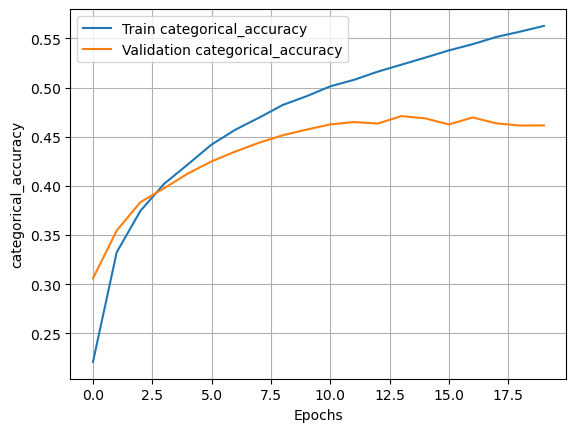

Testing with chunk length: 20
Epoch 1/20
64/64 [==============================] - 12s 149ms/step - loss: 2.7899 - categorical_accuracy: 0.2154 - val_loss: 2.4069 - val_categorical_accuracy: 0.2814
Epoch 2/20
64/64 [==============================] - 9s 135ms/step - loss: 2.1962 - categorical_accuracy: 0.3249 - val_loss: 2.0947 - val_categorical_accuracy: 0.3429
Epoch 3/20
64/64 [==============================] - 9s 142ms/step - loss: 1.9976 - categorical_accuracy: 0.3718 - val_loss: 1.9422 - val_categorical_accuracy: 0.3868
Epoch 4/20
64/64 [==============================] - 10s 157ms/step - loss: 1.8887 - categorical_accuracy: 0.3998 - val_loss: 1.9045 - val_categorical_accuracy: 0.3962
Epoch 5/20
64/64 [==============================] - 10s 151ms/step - loss: 1.8151 - categorical_accuracy: 0.4219 - val_loss: 1.8279 - val_categorical_accuracy: 0.4170
Epoch 6/20
64/64 [==============================] - 10s 161ms/step - loss: 1.7550 - categorical_accuracy: 0.4413 - val_loss: 1.7900 - val

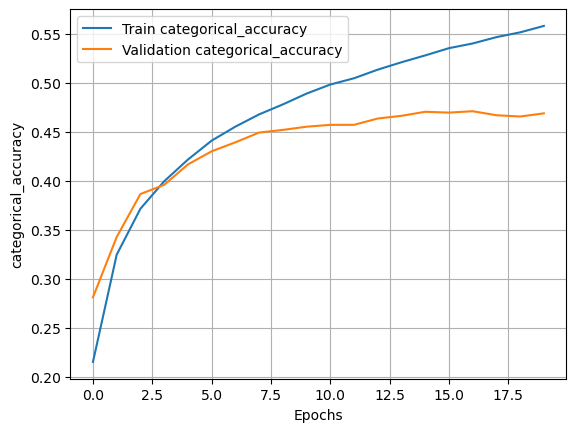

Testing with chunk length: 30
Epoch 1/20
64/64 [==============================] - 16s 224ms/step - loss: 2.8159 - categorical_accuracy: 0.2068 - val_loss: 2.3683 - val_categorical_accuracy: 0.2974
Epoch 2/20
64/64 [==============================] - 16s 243ms/step - loss: 2.2503 - categorical_accuracy: 0.3116 - val_loss: 2.1017 - val_categorical_accuracy: 0.3461
Epoch 3/20
64/64 [==============================] - 15s 228ms/step - loss: 2.0449 - categorical_accuracy: 0.3539 - val_loss: 1.9643 - val_categorical_accuracy: 0.3821
Epoch 4/20
64/64 [==============================] - 15s 232ms/step - loss: 1.9136 - categorical_accuracy: 0.3901 - val_loss: 1.8836 - val_categorical_accuracy: 0.3976
Epoch 5/20
64/64 [==============================] - 14s 222ms/step - loss: 1.8329 - categorical_accuracy: 0.4141 - val_loss: 1.8284 - val_categorical_accuracy: 0.4141
Epoch 6/20
64/64 [==============================] - 16s 246ms/step - loss: 1.7754 - categorical_accuracy: 0.4313 - val_loss: 1.7821 - v

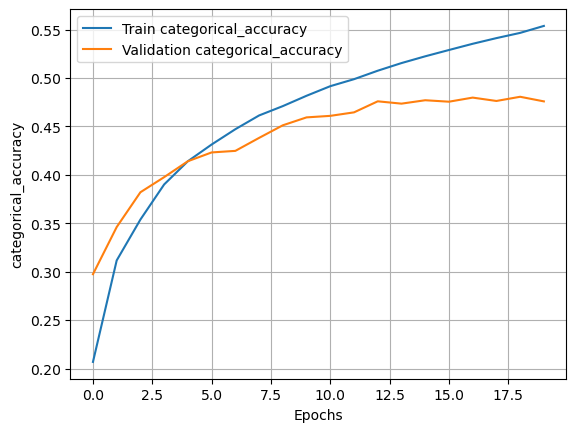

Testing with chunk length: 50
Epoch 1/20
64/64 [==============================] - 26s 377ms/step - loss: 2.7858 - categorical_accuracy: 0.2105 - val_loss: 2.3215 - val_categorical_accuracy: 0.3125
Epoch 2/20
64/64 [==============================] - 24s 375ms/step - loss: 2.2094 - categorical_accuracy: 0.3229 - val_loss: 2.1444 - val_categorical_accuracy: 0.3294
Epoch 3/20
64/64 [==============================] - 23s 359ms/step - loss: 2.0061 - categorical_accuracy: 0.3666 - val_loss: 1.9937 - val_categorical_accuracy: 0.3731
Epoch 4/20
64/64 [==============================] - 23s 357ms/step - loss: 1.8908 - categorical_accuracy: 0.3975 - val_loss: 1.8749 - val_categorical_accuracy: 0.4020
Epoch 5/20
64/64 [==============================] - 25s 395ms/step - loss: 1.8091 - categorical_accuracy: 0.4216 - val_loss: 1.8079 - val_categorical_accuracy: 0.4183
Epoch 6/20
64/64 [==============================] - 28s 443ms/step - loss: 1.7465 - categorical_accuracy: 0.4419 - val_loss: 1.7853 - v

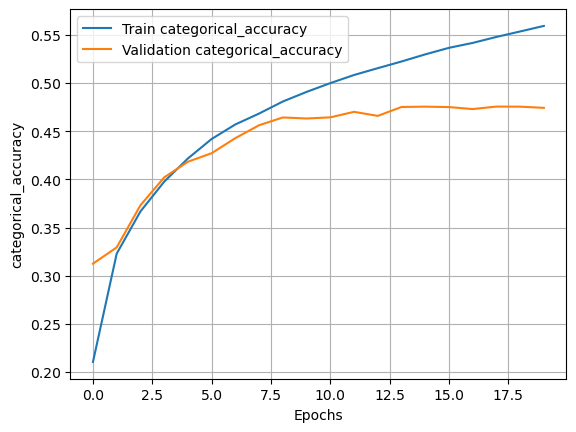

In [26]:
chunk_length_list = []
accuracy_list = []

for chunk_length in [10, 20, 30, 50]:
    print(f"Testing with chunk length: {chunk_length}")
    chunk_length_list.append(chunk_length)
    
    train_x, train_y, val_x, val_y, test_x, test_y = splitting_udf(text, chunk_length)

    model = Sequential()
    model.add(LSTM(128, input_shape=(chunk_length, len(chars))))
    model.add(Dense(len(chars), activation='softmax'))
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
    
    # using categorical accuracy as metric
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
    
    history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=20, batch_size=2048)
    
    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_x, test_y)
    print(f"Test Accuracy: {test_acc}")
    accuracy_list.append(test_acc)
    
    plot_performance(history, "categorical_accuracy")


3.2614301391766407
0.00799524039342164


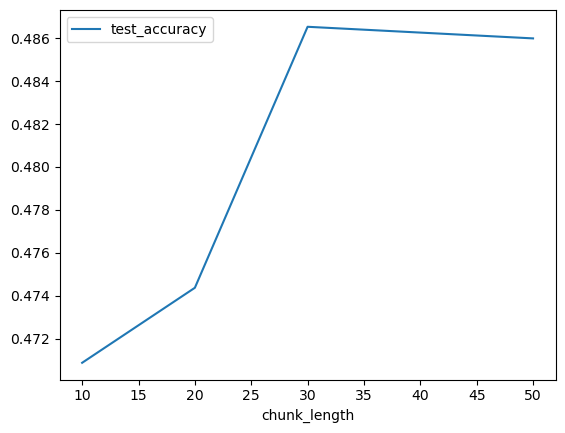

In [41]:
accuracy_test_df = pd.DataFrame({
        "chunk_length": chunk_length_list,
        "test_accuracy": accuracy_list
    }
)

accuracy_test_df.plot(x="chunk_length")

print((accuracy_test_df['test_accuracy'].max() - accuracy_test_df['test_accuracy'].min())/accuracy_test_df['test_accuracy'].mean()*100)
print(accuracy_test_df['test_accuracy'].std())

# Approach 2: Network Architecture


### 2.1 Stacked LSTM - Experiment Description and Results

#### Experiment Overview
This experiment investigates the impact of varying the number of LSTM layers (ranging from 1 to 5) on the categorical accuracy of a character-level sequence prediction model. A fixed sequence chunk length of 30 was used across all tests. The main idea behid this attempt is that adding multiple RNN layers can allow the model to capture hierarchical patterns in the text.

#### Results Summary
- **Test Accuracy**:
  - **2 LSTM layers** achieved the highest accuracy of **0.49**.
  - Accuracy progressively declined as the number of layers increased beyond 2, reaching **0.1** with 4 and 5 layers.
- **Statistical Analysis**:
  - The overall accuracy **standard deviation** is **0.16**.
  - The relative variation in accuracy across the tested configurations is approximately **80%**, demonstrating substantial performance differences based on the number of layers.

#### Interpretation of Results

1. **Performance Peak at 2 Layers**:
   - The highest accuracy observed at 2 LSTM layers suggests that this configuration strikes an optimal balance between model complexity and the ability to learn meaningful patterns. However we have to consider that, despite the fact this configuration got the best accuracy score, the overall performance is very low (less than tossing a coin) and furthemore it doesn't actually perform much better than a simpler architecture with just one LSTM layer.
   - Additional layers introduce excessive complexity and overfitting risks.

2. **Performance Decline with More Layers**:
   - Accuracy drops sharply when the number of LSTM layers exceeds 2. This can be attributed to:
     - **Vanishing Gradient Problem**: Increasing the depth of LSTM layers exacerbates the challenge of learning long-term dependencies.
     - **Overfitting**: The model may overfit to the training data as the number of parameters increases with additional layers.
     - **Optimization Challenges**: Training deeper architectures requires more careful initialization and regularization, which may not have been adequately addressed in this setup.

3. **Plateau at 4-5 Layers**:
   - The accuracy stabilizes at approximately 0.1 for 4 and 5 LSTM layers, suggesting that the model struggles to learn effectively from the data at these depths.


Testing with 1 LSTM layers
Epoch 1/20
64/64 [==============================] - 11s 157ms/step - loss: 2.8120 - categorical_accuracy: 0.2088 - val_loss: 2.3738 - val_categorical_accuracy: 0.2985
Epoch 2/20
64/64 [==============================] - 10s 161ms/step - loss: 2.2350 - categorical_accuracy: 0.3136 - val_loss: 2.0882 - val_categorical_accuracy: 0.3482
Epoch 3/20
64/64 [==============================] - 11s 167ms/step - loss: 2.0103 - categorical_accuracy: 0.3672 - val_loss: 1.9219 - val_categorical_accuracy: 0.3868
Epoch 4/20
64/64 [==============================] - 11s 175ms/step - loss: 1.8921 - categorical_accuracy: 0.3966 - val_loss: 1.8470 - val_categorical_accuracy: 0.4134
Epoch 5/20
64/64 [==============================] - 12s 193ms/step - loss: 1.8169 - categorical_accuracy: 0.4200 - val_loss: 1.8121 - val_categorical_accuracy: 0.4161
Epoch 6/20
64/64 [==============================] - 12s 193ms/step - loss: 1.7555 - categorical_accuracy: 0.4381 - val_loss: 1.7748 - val_

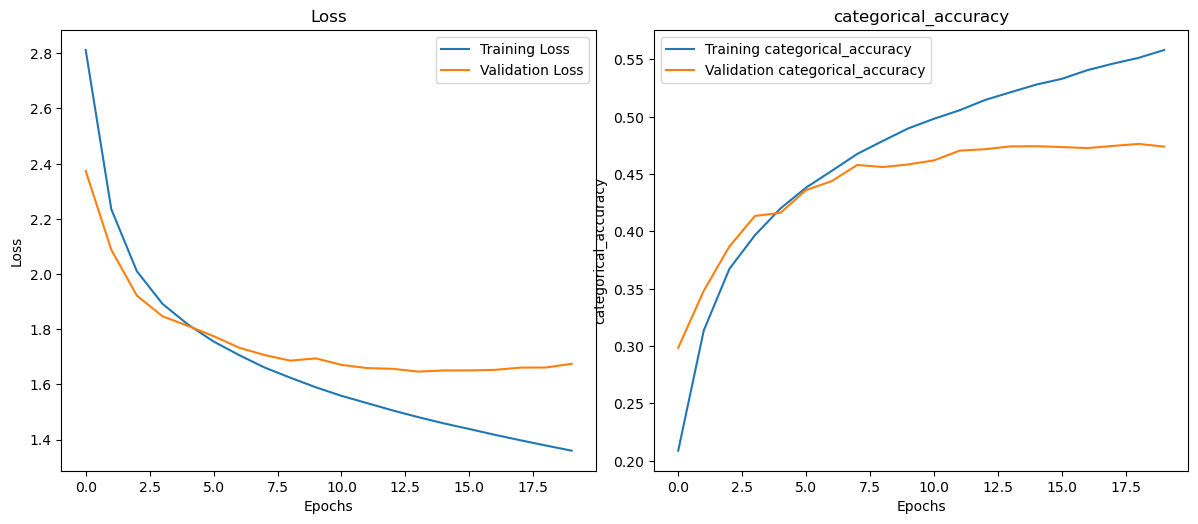

Testing with 2 LSTM layers
Epoch 1/20
64/64 [==============================] - 35s 527ms/step - loss: 3.0228 - categorical_accuracy: 0.1736 - val_loss: 2.6685 - val_categorical_accuracy: 0.2222
Epoch 2/20
64/64 [==============================] - 32s 504ms/step - loss: 2.4416 - categorical_accuracy: 0.2624 - val_loss: 2.2485 - val_categorical_accuracy: 0.3034
Epoch 3/20
64/64 [==============================] - 31s 493ms/step - loss: 2.1592 - categorical_accuracy: 0.3291 - val_loss: 2.1663 - val_categorical_accuracy: 0.3351
Epoch 4/20
64/64 [==============================] - 32s 494ms/step - loss: 2.0156 - categorical_accuracy: 0.3626 - val_loss: 1.9477 - val_categorical_accuracy: 0.3797
Epoch 5/20
64/64 [==============================] - 31s 490ms/step - loss: 1.8986 - categorical_accuracy: 0.3940 - val_loss: 1.8783 - val_categorical_accuracy: 0.3969
Epoch 6/20
64/64 [==============================] - 32s 496ms/step - loss: 1.8145 - categorical_accuracy: 0.4192 - val_loss: 1.8041 - val_

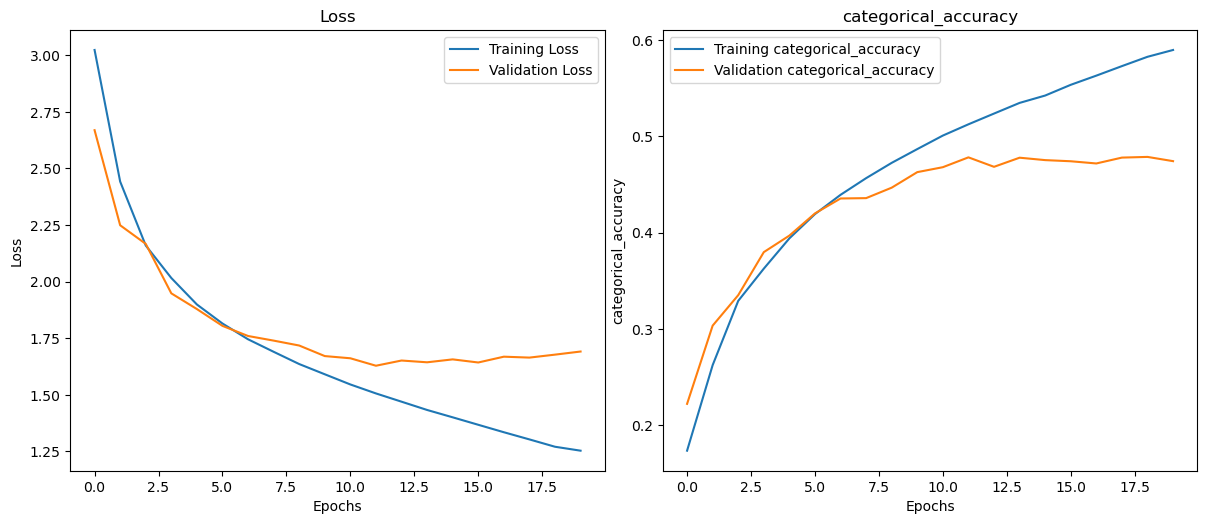

Testing with 3 LSTM layers
Epoch 1/20
64/64 [==============================] - 50s 749ms/step - loss: 3.1444 - categorical_accuracy: 0.1650 - val_loss: 2.9615 - val_categorical_accuracy: 0.1809
Epoch 2/20
64/64 [==============================] - 48s 748ms/step - loss: 2.9773 - categorical_accuracy: 0.1803 - val_loss: 2.9696 - val_categorical_accuracy: 0.1809
Epoch 3/20
64/64 [==============================] - 47s 741ms/step - loss: 2.9722 - categorical_accuracy: 0.1803 - val_loss: 2.9351 - val_categorical_accuracy: 0.1809
Epoch 4/20
64/64 [==============================] - 24857s 395s/step - loss: 2.7671 - categorical_accuracy: 0.2047 - val_loss: 2.5009 - val_categorical_accuracy: 0.2487
Epoch 5/20
64/64 [==============================] - 39157s 622s/step - loss: 2.3912 - categorical_accuracy: 0.2615 - val_loss: 2.3001 - val_categorical_accuracy: 0.2552
Epoch 6/20
64/64 [==============================] - 64s 1s/step - loss: 2.2037 - categorical_accuracy: 0.3052 - val_loss: 2.1703 - val

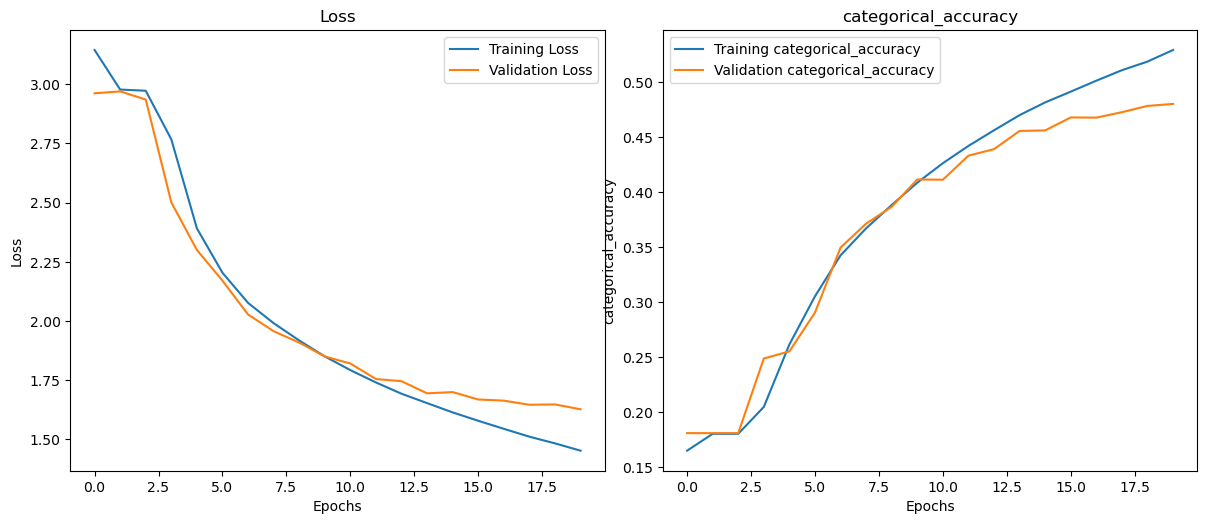

Testing with 4 LSTM layers
Epoch 1/20
64/64 [==============================] - 87s 1s/step - loss: 3.0479 - categorical_accuracy: 0.1713 - val_loss: 2.9618 - val_categorical_accuracy: 0.1809
Epoch 2/20
64/64 [==============================] - 76s 1s/step - loss: 2.9767 - categorical_accuracy: 0.1803 - val_loss: 2.9545 - val_categorical_accuracy: 0.1809
Epoch 3/20
64/64 [==============================] - 75s 1s/step - loss: 2.9755 - categorical_accuracy: 0.1803 - val_loss: 2.9532 - val_categorical_accuracy: 0.1809
Epoch 4/20
64/64 [==============================] - 75s 1s/step - loss: 2.9747 - categorical_accuracy: 0.1803 - val_loss: 2.9511 - val_categorical_accuracy: 0.1809
Epoch 5/20
64/64 [==============================] - 77s 1s/step - loss: 2.9732 - categorical_accuracy: 0.1803 - val_loss: 2.9486 - val_categorical_accuracy: 0.1809
Epoch 6/20
64/64 [==============================] - 78s 1s/step - loss: 2.9726 - categorical_accuracy: 0.1803 - val_loss: 2.9523 - val_categorical_accura

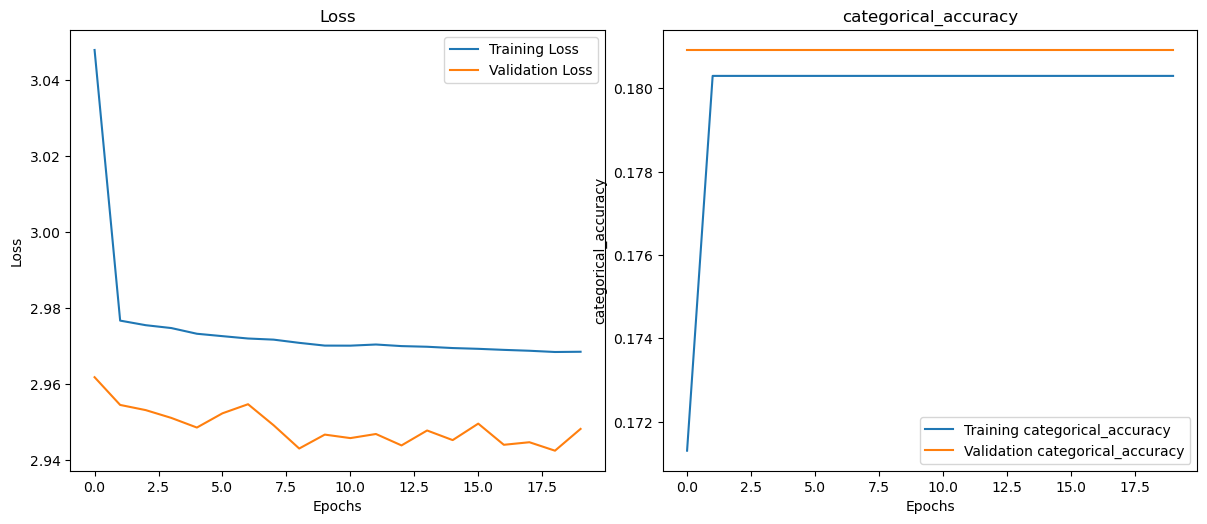

Testing with 5 LSTM layers
Epoch 1/20
64/64 [==============================] - 99s 1s/step - loss: 3.0571 - categorical_accuracy: 0.1682 - val_loss: 2.9559 - val_categorical_accuracy: 0.1809
Epoch 2/20
64/64 [==============================] - 126s 2s/step - loss: 2.9752 - categorical_accuracy: 0.1803 - val_loss: 2.9511 - val_categorical_accuracy: 0.1809
Epoch 3/20
64/64 [==============================] - 271s 4s/step - loss: 2.9711 - categorical_accuracy: 0.1803 - val_loss: 2.9462 - val_categorical_accuracy: 0.1809
Epoch 4/20
64/64 [==============================] - 188s 3s/step - loss: 2.9699 - categorical_accuracy: 0.1803 - val_loss: 2.9475 - val_categorical_accuracy: 0.1809
Epoch 5/20
64/64 [==============================] - 182s 3s/step - loss: 2.9696 - categorical_accuracy: 0.1803 - val_loss: 2.9459 - val_categorical_accuracy: 0.1809
Epoch 6/20
64/64 [==============================] - 183s 3s/step - loss: 2.9691 - categorical_accuracy: 0.1803 - val_loss: 2.9466 - val_categorical_a

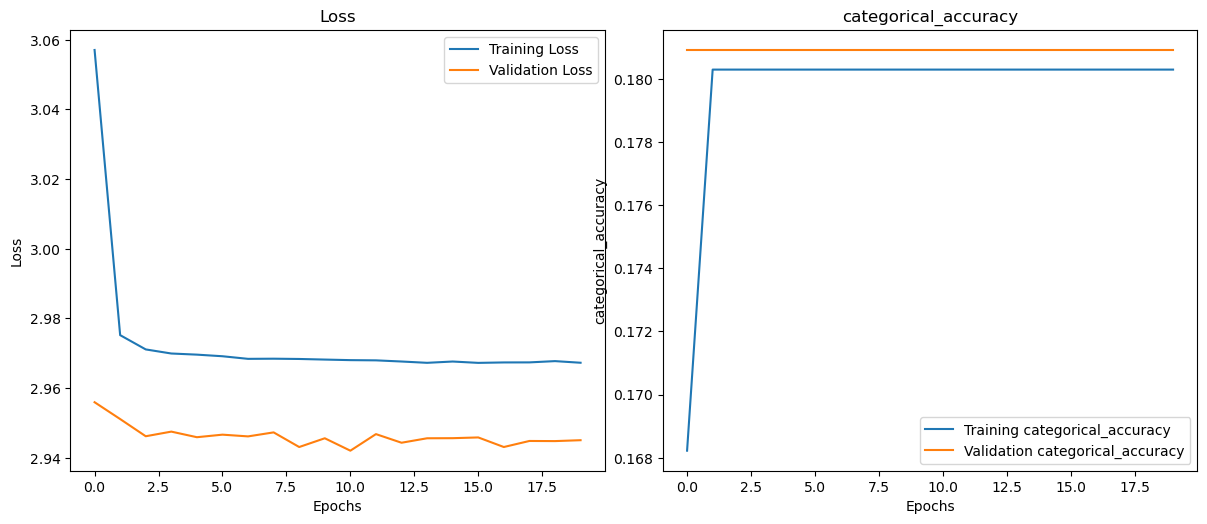

84.52898741824973
0.16767299342595388


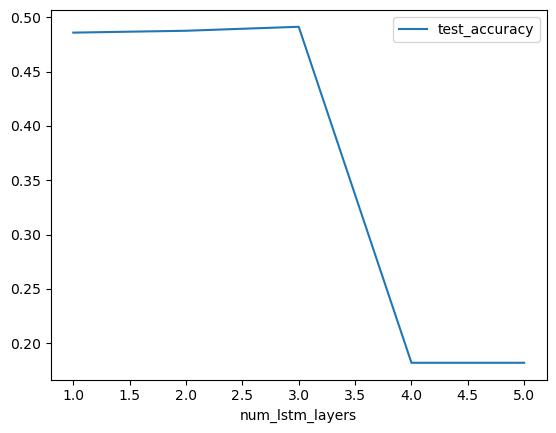

In [36]:
# List to store results for the number of LSTM layers
num_lstm_layers_list = []
accuracy_list = []
chunk_length = 30

for num_lstm_layers in range(1, 6):  # From 1 to 5 layers
    print(f"Testing with {num_lstm_layers} LSTM layers")
    num_lstm_layers_list.append(num_lstm_layers)
    
    train_x, train_y, val_x, val_y, test_x, test_y = splitting_udf(text, chunk_length)

    # Build the model with a variable number of LSTM layers
    model = Sequential()
    for _ in range(num_lstm_layers):
        
        # Return sequences for all but the last layer
        # return_sequences determines whether the layer outputs: 
            # sequence of hidden states for each timestep (return_sequences=True)
            # The final hidden state for the entire input sequence (return_sequences=False, which is the default)
        # return_sequences = True the output shape will be: (batch_size, chunk_length, hidden_units)
            # This becomes the input to the next LSTM
        # The last LSTM layer instead will pass its output to a Dense Layer that expects a fixed-size vector (not a sequence)
            # which is a single vector of shape (batch_size, hidden_units)
        return_sequences = _ < num_lstm_layers - 1
        
        if _ == 0:
            model.add(LSTM(128, return_sequences=return_sequences, input_shape=(chunk_length, len(chars))))
        else:
            # Subsequent LSTM layers infer their input shape from the output of the previous layer
            model.add(LSTM(128, return_sequences=return_sequences))
    
    # Add the final Dense output layer
    model.add(Dense(len(chars), activation='softmax'))
    
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
    
    # Train the model
    history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=20, batch_size=2048)
    
    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_x, test_y)
    print(f"Test Accuracy with {num_lstm_layers} LSTM layers: {test_acc}")
    accuracy_list.append(test_acc)
    
    # Plot the performance
    plot_performance(history, "categorical_accuracy")
    
accuracy_test_df = pd.DataFrame({
        "num_lstm_layers": num_lstm_layers_list,
        "test_accuracy": accuracy_list
    }
)

accuracy_test_df.plot(x="num_lstm_layers")

print((accuracy_test_df['test_accuracy'].max() - accuracy_test_df['test_accuracy'].min())/accuracy_test_df['test_accuracy'].mean()*100)
print(accuracy_test_df['test_accuracy'].std())

84.52898741824973
0.16767299342595388


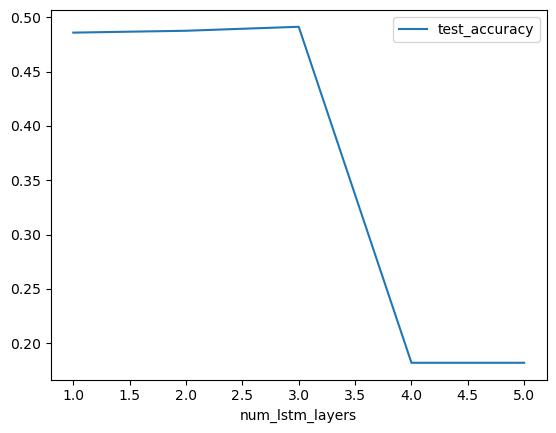

In [37]:
accuracy_test_df = pd.DataFrame({
        "num_lstm_layers": num_lstm_layers_list,
        "test_accuracy": accuracy_list
    }
)

accuracy_test_df.plot(x="num_lstm_layers")

print((accuracy_test_df['test_accuracy'].max() - accuracy_test_df['test_accuracy'].min())/accuracy_test_df['test_accuracy'].mean()*100)
print(accuracy_test_df['test_accuracy'].std())

### 2.2 Regularization Techniques and Clipnorm

This code implements an RNN model using LSTM layers with Dropout regularization and gradient clipping for improved performance and training stability. 

#### Dropout Regularization
Dropout is applied to both LSTM layers (Dropout(0.2)), ensuring that 20% of the neurons are randomly deactivated during training.
This technique helps prevent overfitting by reducing reliance on specific neurons, encouraging the model to generalize better.

#### Gradient Clipping
The model employs gradient clipping with a clipnorm value of 1.0 in the RMSprop optimizer.
Gradient Clipping is a techniques useful to mitigate **exploding gradient**  which can destabilize training.
During backpropagation through time (BPTT), gradients are calculated for each parameter by unrolling the network through time steps. If weights are large, repeated multiplications during backpropagation can cause gradients to grow exponentially, leading to numerical instability.
Gradient clipping constrains the magnitude of gradients during the backpropagation process, ensuring they remain within a pre-defined range. This helps stabilize training and prevents exploding gradients. In particular, according to tensorflow documentation (https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop) if the norm of the gradient vector is higher than the thresold specified in the RMSprop initialization (in our case 1.0), it will be scaled down to fit the threshold.
This ensures smoother convergence, particularly in models with deep LSTM layers or long training sequences.

#### RMSprop Optimizer
Tailored for sequence prediction, it uses an adaptive learning rate for efficient training.

Also in this case we haven't got a really better accuracy score than the previous experiments (always accuracy < 0.5), however we can observe that, likely due to Regularization techniques, training and validation performance are closer than others attempts.

Epoch 1/20
64/64 [==============================] - 80s 1s/step - loss: 3.0411 - categorical_accuracy: 0.1701 - val_loss: 2.9448 - val_categorical_accuracy: 0.1809
Epoch 2/20
64/64 [==============================] - 68s 1s/step - loss: 2.9417 - categorical_accuracy: 0.1797 - val_loss: 2.7531 - val_categorical_accuracy: 0.2087
Epoch 3/20
64/64 [==============================] - 71s 1s/step - loss: 2.6358 - categorical_accuracy: 0.2262 - val_loss: 2.4067 - val_categorical_accuracy: 0.2548
Epoch 4/20
64/64 [==============================] - 69s 1s/step - loss: 2.3943 - categorical_accuracy: 0.2663 - val_loss: 2.2491 - val_categorical_accuracy: 0.3076
Epoch 5/20
64/64 [==============================] - 72s 1s/step - loss: 2.2446 - categorical_accuracy: 0.3006 - val_loss: 2.1372 - val_categorical_accuracy: 0.3263
Epoch 6/20
64/64 [==============================] - 75s 1s/step - loss: 2.1119 - categorical_accuracy: 0.3361 - val_loss: 2.0139 - val_categorical_accuracy: 0.3656
Epoch 7/20
64/64

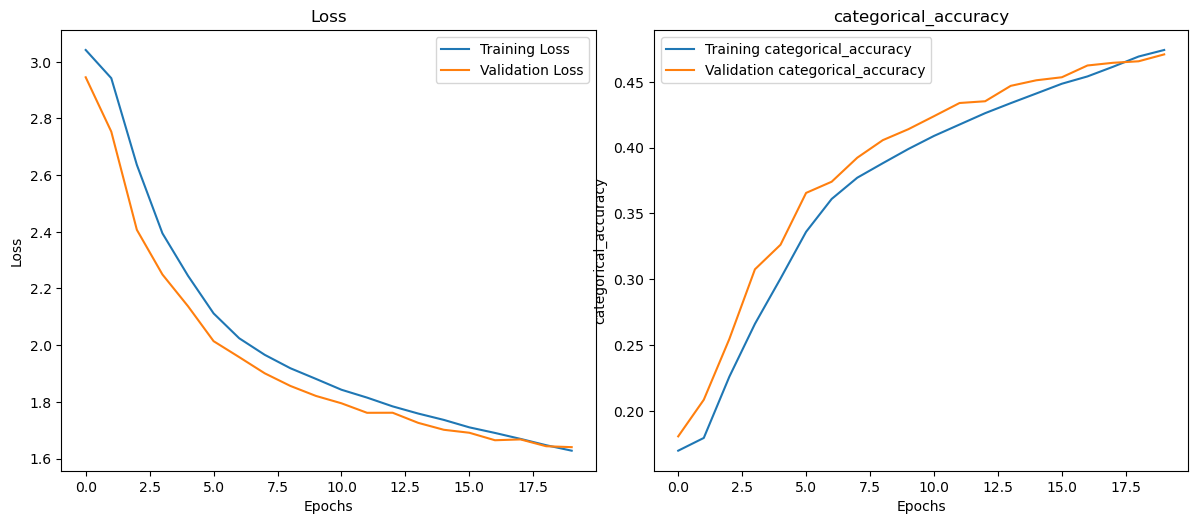

In [56]:
from keras.layers import Dropout

# Parameters
chunk_length = 30  # Fixed chunk length
num_classes = len(chars)  # Number of unique characters

# Splitting data (assuming you have a function for this)
train_x, train_y, val_x, val_y, test_x, test_y = splitting_udf(text, chunk_length)

# Build the model
model = Sequential()
model.add(LSTM(256, input_shape=(chunk_length, len(chars)), return_sequences=True))
model.add(Dropout(0.2))  # Apply dropout to the first LSTM layer
model.add(LSTM(128, return_sequences=False))  # Second LSTM layer
model.add(Dropout(0.2))  # Apply dropout after the second LSTM layer
model.add(Dense(len(chars), activation='softmax'))

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005, clipnorm=1.0)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

# Train the model
history = model.fit(
    train_x, train_y,
    validation_data=(val_x, val_y),
    epochs=20,
    batch_size=2048,
    verbose=1
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_x, test_y, verbose=0)
print(f"Test Accuracy: {test_acc}")

plot_performance(history, "categorical_accuracy")


### 2.3 A further Dense Layer

A further attempt has been realized by adding a fully-connected layer between the last LSTM layer and the softmax function.
In particular this experiment is based on the previous one (2 LSTM layer, each of one followed by a Dropout section for regularization) but it adds a Dense Layer with an ridge regression Regularization. 

However, also for this RNN architecture i got a very poor accuracy score (0.387) against the test dataset.
As for the previous experiment we can observ that Training and validation performance are really close.

Epoch 1/20
64/64 [==============================] - 62s 921ms/step - loss: 3.2296 - categorical_accuracy: 0.1720 - val_loss: 2.9985 - val_categorical_accuracy: 0.1809
Epoch 2/20
64/64 [==============================] - 77s 1s/step - loss: 2.9879 - categorical_accuracy: 0.1803 - val_loss: 2.9641 - val_categorical_accuracy: 0.1809
Epoch 3/20
64/64 [==============================] - 72s 1s/step - loss: 2.9811 - categorical_accuracy: 0.1803 - val_loss: 2.9501 - val_categorical_accuracy: 0.1809
Epoch 4/20
64/64 [==============================] - 74s 1s/step - loss: 2.9772 - categorical_accuracy: 0.1803 - val_loss: 2.9463 - val_categorical_accuracy: 0.1809
Epoch 5/20
64/64 [==============================] - 73s 1s/step - loss: 2.9757 - categorical_accuracy: 0.1803 - val_loss: 2.9454 - val_categorical_accuracy: 0.1809
Epoch 6/20
64/64 [==============================] - 73s 1s/step - loss: 2.9696 - categorical_accuracy: 0.1803 - val_loss: 2.9508 - val_categorical_accuracy: 0.1809
Epoch 7/20
64

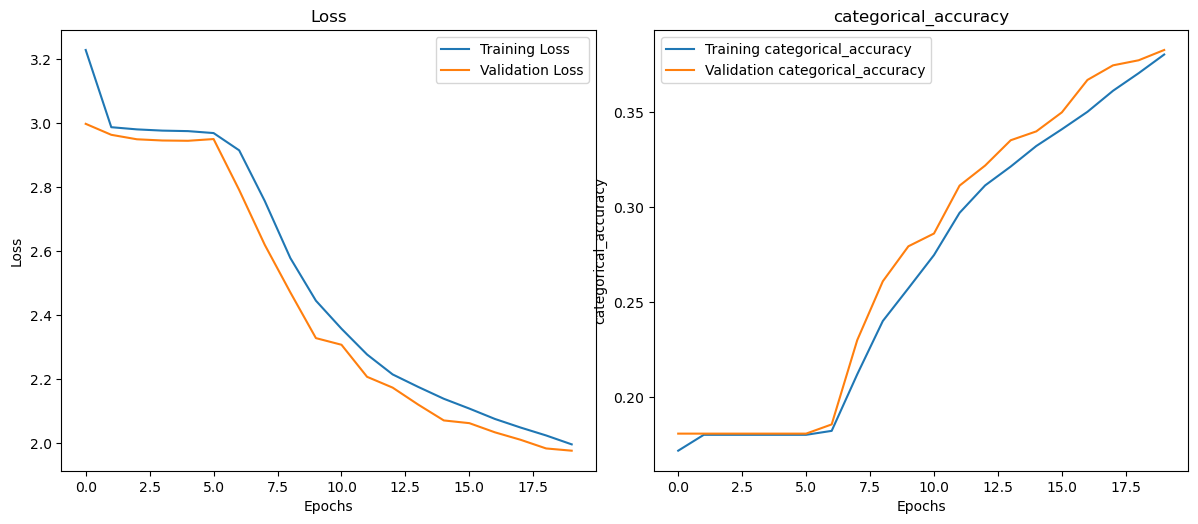

In [33]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras import regularizers
import tensorflow as tf

# Parameters
chunk_length = 30  # Fixed chunk length
num_classes = len(chars)  # Number of unique characters

# Splitting data (assuming you have a function for this)
train_x, train_y, val_x, val_y, test_x, test_y = splitting_udf(text, chunk_length)

# Build the model
model = Sequential()
model.add(LSTM(256, input_shape=(chunk_length, len(chars)), return_sequences=True))
model.add(Dropout(0.2))  # Apply dropout to the first LSTM layer
model.add(LSTM(128, return_sequences=False))  # Second LSTM layer
model.add(Dropout(0.2))  # Apply dropout after the second LSTM layer

# Add a dense layer with L2 regularization
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Final softmax layer
model.add(Dense(len(chars), activation='softmax'))

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005, clipnorm=1.0)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

# Train the model
history = model.fit(
    train_x, train_y,
    validation_data=(val_x, val_y),
    epochs=20,
    batch_size=2048,
    verbose=1
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_x, test_y, verbose=0)
print(f"Test Accuracy: {test_acc}")

plot_performance(history, "categorical_accuracy")


## Approach 3.0: Optimizing Performance Through Units Number, Batch Size and Learning Rate

In the following approach i tried an hybrid approach tuning on the number of layer but on a layer with some difference in respect of the previous configurations. In particular i have:
 - Increased the number of units of each LSTM layer
 - Reduced the batch size
 - Decreased the learning rate
 
#### Increasing the number of units of each LSTM layer
Adding more units increases the network's capacity to learn complex patterns by capturing more intricate temporal dependencies in the data. Each unit adds more weights and biases, enabling the model to better represent subtle variations in the input sequences.
I decided to increase this hyperparams due to the fact that all the previous models underfitted (in terms of performance) both training and validation dataset.
Of course, this complexity increased could potentially lead to an overfitting related to the training set, so i add dropout as regularization techniques.

#### Reducing Batch Size
A smaller batch size results in more frequent gradient updates per epoch. This can improve convergence in complex non-convex optimization problems by introducing noise to escape saddle points and local minima. Local minima, of course, could be one of the problems of the previous model.


#### Decreasing Learning Rate:
A lower learning rate allows the model to make smaller and more precise updates to weights, which can prevent overshooting the optimal solution and ensure convergence to a better minimum.
Obviously this approach will lead to a slower training.



### Results:

As shown below, this new combination of hyperparameters values achieved the best test accuracy score for the moment (0.51). 
In particular, the best performance has been associated to the following combination: 
- 1 LSTM Layer
- 512 units for the LSTM layer
- 0.001 learning rate
- 128 as batch size

Considering the fact that the accuracy hasn't really changed between the model of 1 LSTM layer and the architecture with 2 LSTM layer (0.0001 of standard deviation between the two experiments), it's reasonable thinking that the main performance improvements are related to the three mentioned hyperparameters.

Testing with 1 LSTM layers

Epoch 1/20


1018/1018 [==============================] - 203s 198ms/step - loss: 2.5041 - categorical_accuracy: 0.2641 - val_loss: 2.1642 - val_categorical_accuracy: 0.3250
Epoch 2/20
1018/1018 [==============================] - 206s 202ms/step - loss: 2.1585 - categorical_accuracy: 0.3328 - val_loss: 1.9566 - val_categorical_accuracy: 0.3836
Epoch 3/20
1018/1018 [==============================] - 206s 202ms/step - loss: 2.0316 - categorical_accuracy: 0.3645 - val_loss: 1.8676 - val_categorical_accuracy: 0.4052
Epoch 4/20
1018/1018 [==============================] - 211s 207ms/step - loss: 1.9458 - categorical_accuracy: 0.3866 - val_loss: 1.8260 - val_categorical_accuracy: 0.4126
Epoch 5/20
1018/1018 [==============================] - 206s 202ms/step - loss: 1.8788 - categorical_accuracy: 0.4061 - val_loss: 1.7693 - val_categorical_accuracy: 0.4334
Epoch 6/20
1018/1018 [==============================] - 204s 201ms/step - loss: 1.8232 - categorical_accuracy:

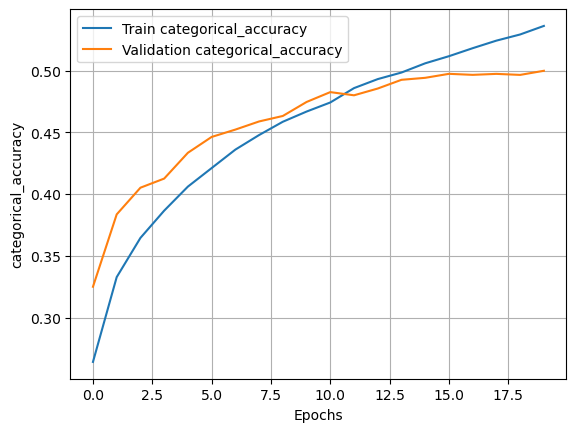

Testing with 2 LSTM layers
Epoch 1/20
1018/1018 [==============================] - 349s 340ms/step - loss: 2.6143 - categorical_accuracy: 0.2398 - val_loss: 2.1961 - val_categorical_accuracy: 0.3291
Epoch 2/20
1018/1018 [==============================] - 337s 331ms/step - loss: 2.2317 - categorical_accuracy: 0.3172 - val_loss: 2.0046 - val_categorical_accuracy: 0.3665
Epoch 3/20
1018/1018 [==============================] - 344s 338ms/step - loss: 2.1055 - categorical_accuracy: 0.3464 - val_loss: 1.8976 - val_categorical_accuracy: 0.4031
Epoch 4/20
1018/1018 [==============================] - 336s 330ms/step - loss: 1.9928 - categorical_accuracy: 0.3716 - val_loss: 1.8403 - val_categorical_accuracy: 0.4107
Epoch 5/20
1018/1018 [==============================] - 2830s 3s/step - loss: 1.9160 - categorical_accuracy: 0.3916 - val_loss: 1.7869 - val_categorical_accuracy: 0.4280
Epoch 6/20
1018/1018 [==============================] - 331s 325ms/step - loss: 1.8548 - categorical_accuracy: 0.40

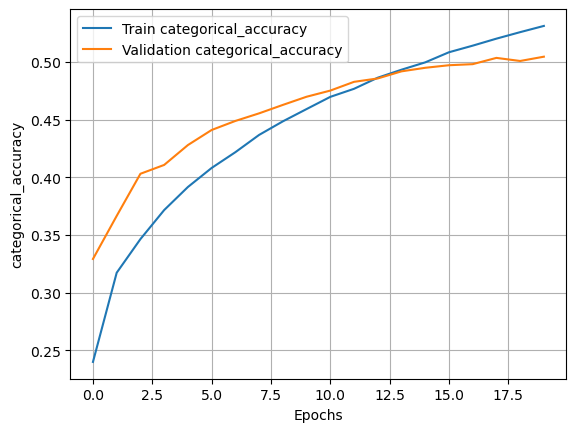

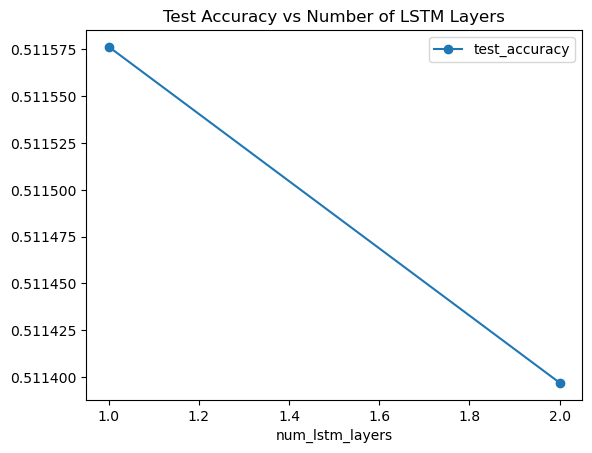

Max accuracy: 0.511576235294342
Min accuracy: 0.5113970041275024
Standard deviation: 0.00012673557347225834


In [6]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# Function to plot training history
def plot_performance(history, metric):
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.grid()
    plt.show()

# List to store results for the number of LSTM layers
num_lstm_layers_list = []
accuracy_list = []
chunk_length = 30  # Sequence length

# Iterate over 1 to 2 LSTM layers
for num_lstm_layers in range(1, 3):
    print(f"Testing with {num_lstm_layers} LSTM layers")
    num_lstm_layers_list.append(num_lstm_layers)

    # Load and preprocess data
    train_x, train_y, val_x, val_y, test_x, test_y = splitting_udf(text, chunk_length, step=3, train_perc=0.7, val_perc=0.15)

    # Build the model
    model = Sequential()
    for layer_idx in range(num_lstm_layers):
        return_sequences = layer_idx < num_lstm_layers - 1  # Return sequences for all but the last layer
        if layer_idx == 0:
            # First layer requires input shape
            model.add(LSTM(512, return_sequences=return_sequences, input_shape=(chunk_length, len(chars)), 
                           dropout=0.2, recurrent_dropout=0.2))
        else:
            # Subsequent layers infer input shape
            model.add(LSTM(256, return_sequences=return_sequences, 
                           dropout=0.2, recurrent_dropout=0.2))

    # Add the final Dense output layer
    model.add(Dense(len(chars), activation='softmax'))

    # Compile the model with gradient clipping
    optimizer = RMSprop(learning_rate=0.001, clipvalue=1.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

    # Train the model
    history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=20, batch_size=128)

    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_x, test_y)
    print(f"Test Accuracy with {num_lstm_layers} LSTM layers: {test_acc}")
    accuracy_list.append(test_acc)

    # Plot the performance
    plot_performance(history, "categorical_accuracy")

# Create a DataFrame to analyze results
import pandas as pd
accuracy_test_df = pd.DataFrame({
    "num_lstm_layers": num_lstm_layers_list,
    "test_accuracy": accuracy_list
})

# Plot the accuracy results
accuracy_test_df.plot(x="num_lstm_layers", y="test_accuracy", marker='o', title="Test Accuracy vs Number of LSTM Layers")
plt.show()

# Print summary statistics
print(f"Max accuracy: {accuracy_test_df['test_accuracy'].max()}")
print(f"Min accuracy: {accuracy_test_df['test_accuracy'].min()}")
print(f"Standard deviation: {accuracy_test_df['test_accuracy'].std()}")


## Approach 3.1: Focusing on LSTM Units Number

Considering the described result of the previous experiment, i decided to follow this path and start to isolate the three hyperparams by conducting three independent fine-tuning on each hyperparams, starting from LSTM Units Number.

So the following experiments (from 3.1 to 3.3) will be aimed to understand if there is a unique independent cause in the increased accuracy of the previous experiment (or in the opposite, the better performance is the result of a more complex interaction between the updated hyperparameters).

Experimet Details:

I have set learning rate an batch size at the previous values:
- Learning rate = 0.005
- Batch Size = 2048

And i fine-tune only the lstm units for: 512, 1024, 2048.

As shown below, in the test results, increasing only the number of units related to the LSTM layer does not lead to an increase of accuracy score as we have seen in the previous experiment (but rather it seems to be getting worse the model performance):

- lstm units: 512, 1024, 2048
- accuracy score: 0.47, 0.46, Nan (it was taken too much time)

Testing with 512 LSTM units
Epoch 1/20
64/64 [==============================] - 136s 2s/step - loss: 3.1536 - categorical_accuracy: 0.1558 - val_loss: 2.9199 - val_categorical_accuracy: 0.1809
Epoch 2/20
64/64 [==============================] - 128s 2s/step - loss: 2.7442 - categorical_accuracy: 0.2149 - val_loss: 2.5677 - val_categorical_accuracy: 0.2321
Epoch 3/20
64/64 [==============================] - 153s 2s/step - loss: 2.4813 - categorical_accuracy: 0.2633 - val_loss: 2.3111 - val_categorical_accuracy: 0.2994
Epoch 4/20
64/64 [==============================] - 132s 2s/step - loss: 2.3299 - categorical_accuracy: 0.2931 - val_loss: 2.1867 - val_categorical_accuracy: 0.3222
Epoch 5/20
64/64 [==============================] - 137s 2s/step - loss: 2.2244 - categorical_accuracy: 0.3155 - val_loss: 2.0817 - val_categorical_accuracy: 0.3486
Epoch 6/20
64/64 [==============================] - 138s 2s/step - loss: 2.1534 - categorical_accuracy: 0.3306 - val_loss: 2.0041 - val_categorical

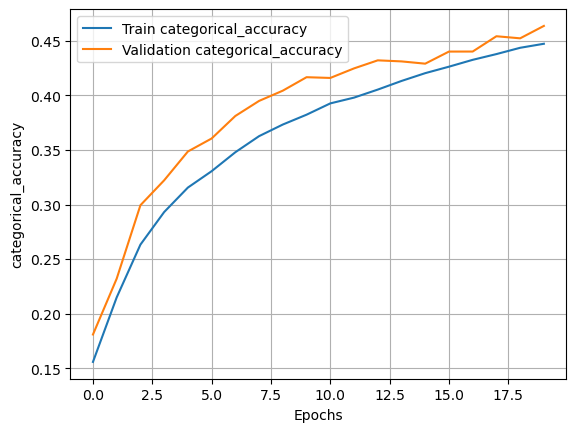

Testing with 1024 LSTM units
Epoch 1/20
64/64 [==============================] - 373s 6s/step - loss: 3.4862 - categorical_accuracy: 0.1420 - val_loss: 3.3965 - val_categorical_accuracy: 0.0900
Epoch 2/20
64/64 [==============================] - 369s 6s/step - loss: 2.9585 - categorical_accuracy: 0.1742 - val_loss: 2.7381 - val_categorical_accuracy: 0.2313
Epoch 3/20
64/64 [==============================] - 358s 6s/step - loss: 2.6854 - categorical_accuracy: 0.2190 - val_loss: 2.4769 - val_categorical_accuracy: 0.2629
Epoch 4/20
64/64 [==============================] - 368s 6s/step - loss: 2.4819 - categorical_accuracy: 0.2600 - val_loss: 2.2983 - val_categorical_accuracy: 0.2946
Epoch 5/20
64/64 [==============================] - 399s 6s/step - loss: 2.3350 - categorical_accuracy: 0.2914 - val_loss: 2.1641 - val_categorical_accuracy: 0.3236
Epoch 6/20
64/64 [==============================] - 386s 6s/step - loss: 2.2313 - categorical_accuracy: 0.3121 - val_loss: 2.1429 - val_categorica

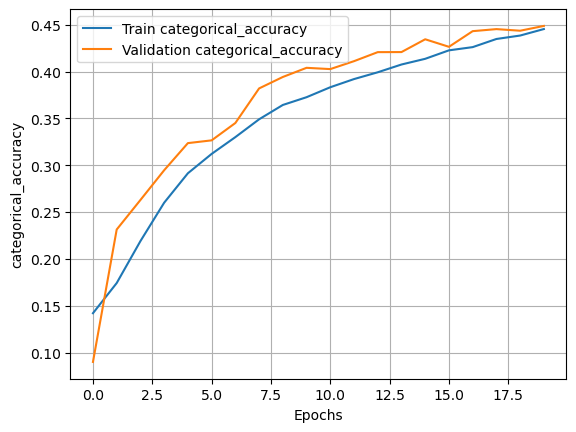

Testing with 2048 LSTM units
Epoch 1/20
64/64 [==============================] - 1680s 26s/step - loss: 4.4064 - categorical_accuracy: 0.1200 - val_loss: 3.0341 - val_categorical_accuracy: 0.1809
Epoch 2/20
64/64 [==============================] - 1433s 22s/step - loss: 2.9980 - categorical_accuracy: 0.1636 - val_loss: 2.9697 - val_categorical_accuracy: 0.1809
Epoch 3/20
64/64 [==============================] - 1618s 25s/step - loss: 2.8144 - categorical_accuracy: 0.1914 - val_loss: 2.6569 - val_categorical_accuracy: 0.2146
Epoch 4/20
64/64 [==============================] - 1530s 24s/step - loss: 2.6299 - categorical_accuracy: 0.2282 - val_loss: 2.4601 - val_categorical_accuracy: 0.2579
Epoch 5/20
63/64 [============================>.] - ETA: 21s - loss: 2.4837 - categorical_accuracy: 0.2551

KeyboardInterrupt: 

In [7]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# Function to plot training history
def plot_performance(history, metric):
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.grid()
    plt.show()

# List to store results for different LSTM units
lstm_units_list = [512, 1024, 2048]
accuracy_list = []
chunk_length = 30  # Sequence length

# Iterate over LSTM units
for lstm_units in lstm_units_list:
    print(f"Testing with {lstm_units} LSTM units")

    # Load and preprocess data
    train_x, train_y, val_x, val_y, test_x, test_y = splitting_udf(
        text, chunk_length, step=3, train_perc=0.7, val_perc=0.15
    )

    # Build the model
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(chunk_length, len(chars)), 
                   dropout=0.2, recurrent_dropout=0.2))

    # Add the final Dense output layer
    model.add(Dense(len(chars), activation='softmax'))

    # Compile the model with gradient clipping
    optimizer = RMSprop(learning_rate=0.005, clipvalue=1.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

    # Train the model
    history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=20, batch_size=2048)

    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_x, test_y)
    print(f"Test Accuracy with {lstm_units} LSTM units: {test_acc}")
    accuracy_list.append(test_acc)

    # Plot the performance
    plot_performance(history, "categorical_accuracy")

# Create a DataFrame to analyze results
import pandas as pd
accuracy_test_df = pd.DataFrame({
    "lstm_units": lstm_units_list,
    "test_accuracy": accuracy_list
})

# Plot the accuracy results
accuracy_test_df.plot(x="lstm_units", y="test_accuracy", marker='o', title="Test Accuracy vs LSTM Units")
plt.show()

# Print summary statistics
print(f"Max accuracy: {accuracy_test_df['test_accuracy'].max()}")
print(f"Min accuracy: {accuracy_test_df['test_accuracy'].min()}")
print(f"Standard deviation: {accuracy_test_df['test_accuracy'].std()}")


## Approach 3.2: Focusing on Learning Rate

In the experiment below i trained three models each one with half the learning rate of the previous one. As it's possible to observe the model's performance decreases as the learning rate decreases this may be due to several reasons:
- A too-low learning rate makes the updates small, slowing down convergence and causing the model to spend excessive time in suboptimal regions of the loss landscape.
- The gradient descent attempt may be stuck in a local minima or in saddle point (this can be the reason why in the last experiment accuracy score remains the same for several epochs)
- More in general a training a model with a smaller learning rate but equal number of epochs could lead avoid the model converges
- In RNN smaller weight updates (due to a small learning rate) exacerbate the difficulty of propagating information back through many time steps.

Testing with learning rate: 0.001
Epoch 1/20
64/64 [==============================] - 44s 657ms/step - loss: 3.0157 - categorical_accuracy: 0.1768 - val_loss: 2.9134 - val_categorical_accuracy: 0.1809
Epoch 2/20
64/64 [==============================] - 42s 653ms/step - loss: 2.8845 - categorical_accuracy: 0.1910 - val_loss: 2.7827 - val_categorical_accuracy: 0.2359
Epoch 3/20
64/64 [==============================] - 42s 664ms/step - loss: 2.6991 - categorical_accuracy: 0.2283 - val_loss: 2.5378 - val_categorical_accuracy: 0.2341
Epoch 4/20
64/64 [==============================] - 41s 642ms/step - loss: 2.5345 - categorical_accuracy: 0.2602 - val_loss: 2.3993 - val_categorical_accuracy: 0.2917
Epoch 5/20
64/64 [==============================] - 42s 664ms/step - loss: 2.4392 - categorical_accuracy: 0.2808 - val_loss: 2.2969 - val_categorical_accuracy: 0.3181
Epoch 6/20
64/64 [==============================] - 42s 655ms/step - loss: 2.3770 - categorical_accuracy: 0.2893 - val_loss: 2.2324

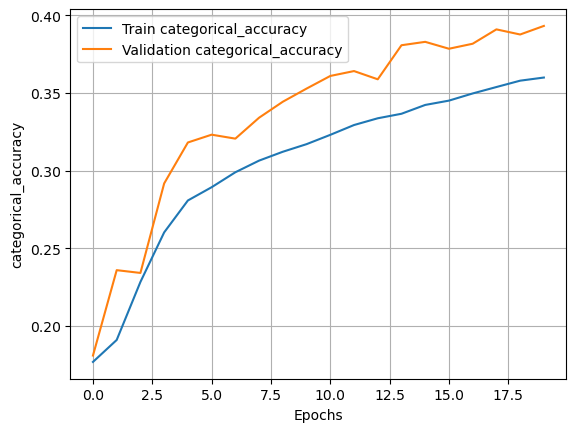

Testing with learning rate: 0.0005
Epoch 1/20
64/64 [==============================] - 48s 694ms/step - loss: 3.0548 - categorical_accuracy: 0.1762 - val_loss: 2.9278 - val_categorical_accuracy: 0.1809
Epoch 2/20
64/64 [==============================] - 42s 662ms/step - loss: 2.9382 - categorical_accuracy: 0.1805 - val_loss: 2.8931 - val_categorical_accuracy: 0.1809
Epoch 3/20
64/64 [==============================] - 43s 665ms/step - loss: 2.8917 - categorical_accuracy: 0.1870 - val_loss: 2.8299 - val_categorical_accuracy: 0.2405
Epoch 4/20
64/64 [==============================] - 42s 652ms/step - loss: 2.8020 - categorical_accuracy: 0.2091 - val_loss: 2.6928 - val_categorical_accuracy: 0.2437
Epoch 5/20
64/64 [==============================] - 42s 655ms/step - loss: 2.6825 - categorical_accuracy: 0.2335 - val_loss: 2.5882 - val_categorical_accuracy: 0.2693
Epoch 6/20
64/64 [==============================] - 42s 662ms/step - loss: 2.5875 - categorical_accuracy: 0.2517 - val_loss: 2.486

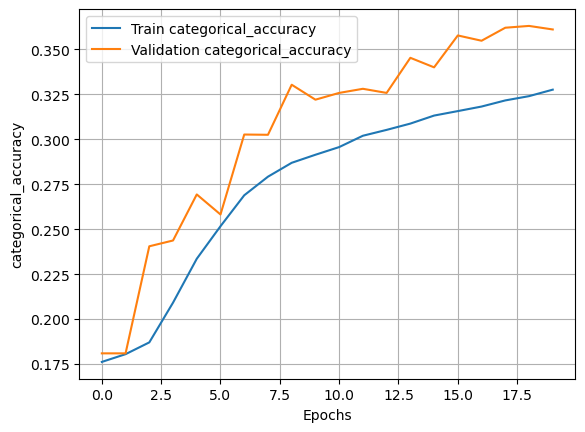

Testing with learning rate: 0.0001
Epoch 1/20
64/64 [==============================] - 43s 660ms/step - loss: 3.3998 - categorical_accuracy: 0.1669 - val_loss: 3.0066 - val_categorical_accuracy: 0.1809
Epoch 2/20
64/64 [==============================] - 42s 651ms/step - loss: 2.9883 - categorical_accuracy: 0.1803 - val_loss: 2.9434 - val_categorical_accuracy: 0.1809
Epoch 3/20
64/64 [==============================] - 42s 652ms/step - loss: 2.9624 - categorical_accuracy: 0.1803 - val_loss: 2.9322 - val_categorical_accuracy: 0.1809
Epoch 4/20
64/64 [==============================] - 41s 647ms/step - loss: 2.9537 - categorical_accuracy: 0.1803 - val_loss: 2.9257 - val_categorical_accuracy: 0.1809
Epoch 5/20
64/64 [==============================] - 41s 647ms/step - loss: 2.9468 - categorical_accuracy: 0.1803 - val_loss: 2.9175 - val_categorical_accuracy: 0.1809
Epoch 6/20
64/64 [==============================] - 41s 644ms/step - loss: 2.9399 - categorical_accuracy: 0.1803 - val_loss: 2.910

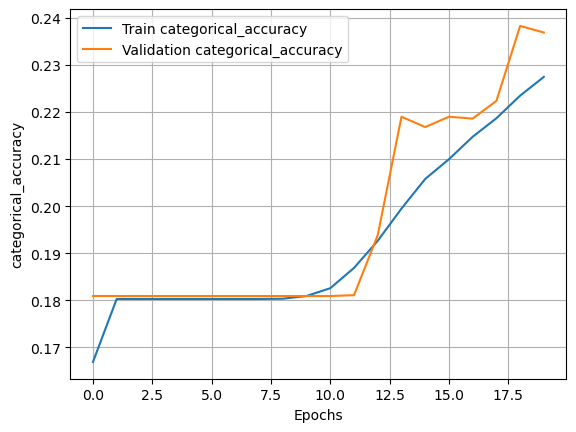

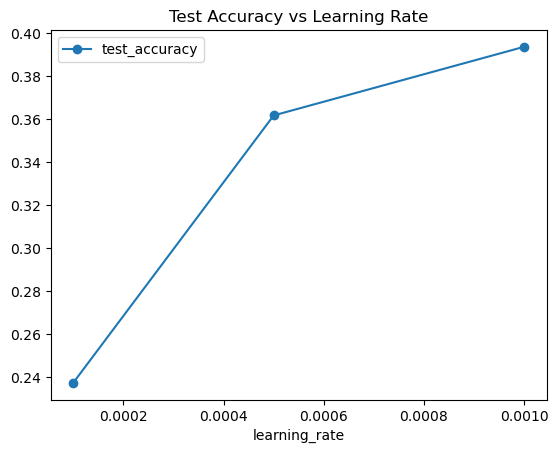

Max accuracy: 0.39362770318984985
Min accuracy: 0.23718729615211487
Standard deviation: 0.08265262807671588


In [8]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# Function to plot training history
def plot_performance(history, metric):
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.grid()
    plt.show()

# List to store results for different learning rates
learning_rates = [0.001, 0.0005, 0.0001]
accuracy_list = []
chunk_length = 30  # Sequence length
lstm_units = 256  # Fixed LSTM units for this test

# Iterate over learning rates
for lr in learning_rates:
    print(f"Testing with learning rate: {lr}")

    # Load and preprocess data
    train_x, train_y, val_x, val_y, test_x, test_y = splitting_udf(
        text, chunk_length, step=3, train_perc=0.7, val_perc=0.15
    )

    # Build the model
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(chunk_length, len(chars)), 
                   dropout=0.2, recurrent_dropout=0.2))

    # Add the final Dense output layer
    model.add(Dense(len(chars), activation='softmax'))

    # Compile the model with gradient clipping
    optimizer = RMSprop(learning_rate=lr, clipvalue=1.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

    # Train the model
    history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=20, batch_size=2048)

    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_x, test_y)
    print(f"Test Accuracy with learning rate {lr}: {test_acc}")
    accuracy_list.append(test_acc)

    # Plot the performance
    plot_performance(history, "categorical_accuracy")

# Create a DataFrame to analyze results
import pandas as pd
accuracy_test_df = pd.DataFrame({
    "learning_rate": learning_rates,
    "test_accuracy": accuracy_list
})

# Plot the accuracy results
accuracy_test_df.plot(x="learning_rate", y="test_accuracy", marker='o', title="Test Accuracy vs Learning Rate")
plt.show()

# Print summary statistics
print(f"Max accuracy: {accuracy_test_df['test_accuracy'].max()}")
print(f"Min accuracy: {accuracy_test_df['test_accuracy'].min()}")
print(f"Standard deviation: {accuracy_test_df['test_accuracy'].std()}")


## Approach 3.3: Focusing on Batch Size

From this last sequence of fine-tuning is it possible to observ that the best batch size value for the performance is 128.
So the batch size seems to be the most imporat factor related to the increase of performance of the Approach 3.0. In fact, all the test with batch size lower than 2048 (batch_sizes = [128, 64, 32]) were associated to an accuracy score greater than 0.5. In particular, 128 was the batch size value associated to the best compromise between large and small batch sizes.

A large batch size like 2048 provides smoother gradient updates since they average over more samples. However, it can lead to poor generalization due to reduced stochasticity and slower progress per epoch (more computation required per step).

Small Batch Sizes (like 32, 64) allow the model to take more frequent updates, introducing noise in the gradient estimation, which can help escape local minima but might also slow down convergence.



Testing with batch size: 128
Epoch 1/20
1018/1018 [==============================] - 76s 73ms/step - loss: 2.2314 - categorical_accuracy: 0.3183 - val_loss: 1.8783 - val_categorical_accuracy: 0.4022
Epoch 2/20
1018/1018 [==============================] - 78s 77ms/step - loss: 1.8903 - categorical_accuracy: 0.3995 - val_loss: 1.7617 - val_categorical_accuracy: 0.4323
Epoch 3/20
1018/1018 [==============================] - 76s 75ms/step - loss: 1.7777 - categorical_accuracy: 0.4332 - val_loss: 1.6794 - val_categorical_accuracy: 0.4592
Epoch 4/20
1018/1018 [==============================] - 76s 75ms/step - loss: 1.7068 - categorical_accuracy: 0.4544 - val_loss: 1.6387 - val_categorical_accuracy: 0.4681
Epoch 5/20
1018/1018 [==============================] - 76s 75ms/step - loss: 1.6574 - categorical_accuracy: 0.4684 - val_loss: 1.6188 - val_categorical_accuracy: 0.4758
Epoch 6/20
1018/1018 [==============================] - 75s 74ms/step - loss: 1.6192 - categorical_accuracy: 0.4783 - val

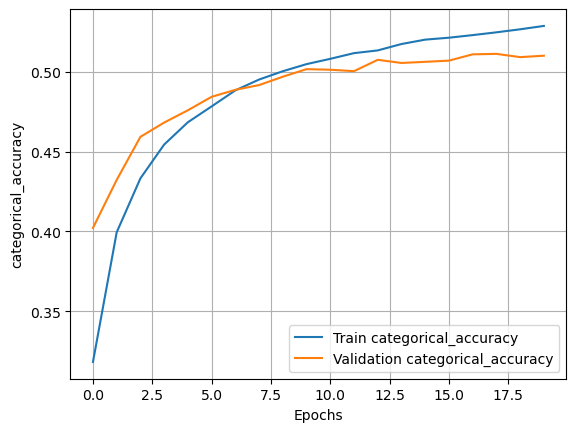

Testing with batch size: 64
Epoch 1/20
2036/2036 [==============================] - 104s 51ms/step - loss: 2.1376 - categorical_accuracy: 0.3410 - val_loss: 1.8283 - val_categorical_accuracy: 0.4184
Epoch 2/20
2036/2036 [==============================] - 100s 49ms/step - loss: 1.8321 - categorical_accuracy: 0.4180 - val_loss: 1.7172 - val_categorical_accuracy: 0.4462
Epoch 3/20
2036/2036 [==============================] - 98s 48ms/step - loss: 1.7348 - categorical_accuracy: 0.4479 - val_loss: 1.6691 - val_categorical_accuracy: 0.4644
Epoch 4/20
2036/2036 [==============================] - 99s 49ms/step - loss: 1.6762 - categorical_accuracy: 0.4642 - val_loss: 1.6320 - val_categorical_accuracy: 0.4768
Epoch 5/20
2036/2036 [==============================] - 96s 47ms/step - loss: 1.6380 - categorical_accuracy: 0.4765 - val_loss: 1.6089 - val_categorical_accuracy: 0.4782
Epoch 6/20
2036/2036 [==============================] - 98s 48ms/step - loss: 1.6131 - categorical_accuracy: 0.4847 - va

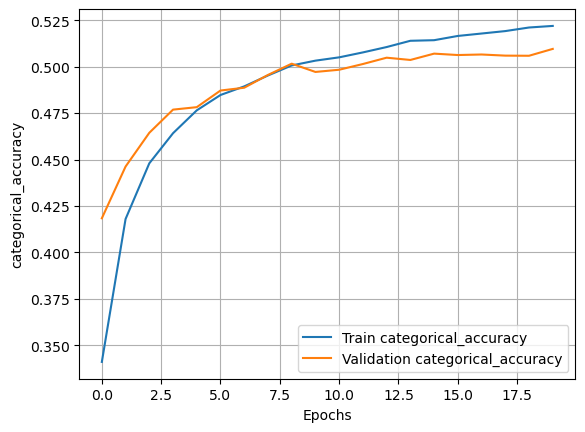

Testing with batch size: 32
Epoch 1/20
4071/4071 [==============================] - 181s 44ms/step - loss: 2.0832 - categorical_accuracy: 0.3546 - val_loss: 1.8001 - val_categorical_accuracy: 0.4244
Epoch 2/20
4071/4071 [==============================] - 178s 44ms/step - loss: 1.8121 - categorical_accuracy: 0.4276 - val_loss: 1.6974 - val_categorical_accuracy: 0.4585
Epoch 3/20
4071/4071 [==============================] - 167s 41ms/step - loss: 1.7362 - categorical_accuracy: 0.4507 - val_loss: 1.6581 - val_categorical_accuracy: 0.4713
Epoch 4/20
4071/4071 [==============================] - 170s 42ms/step - loss: 1.6971 - categorical_accuracy: 0.4630 - val_loss: 1.6333 - val_categorical_accuracy: 0.4743
Epoch 5/20
4071/4071 [==============================] - 165s 41ms/step - loss: 1.6757 - categorical_accuracy: 0.4723 - val_loss: 1.6227 - val_categorical_accuracy: 0.4788
Epoch 6/20
4071/4071 [==============================] - 164s 40ms/step - loss: 1.6578 - categorical_accuracy: 0.4764 

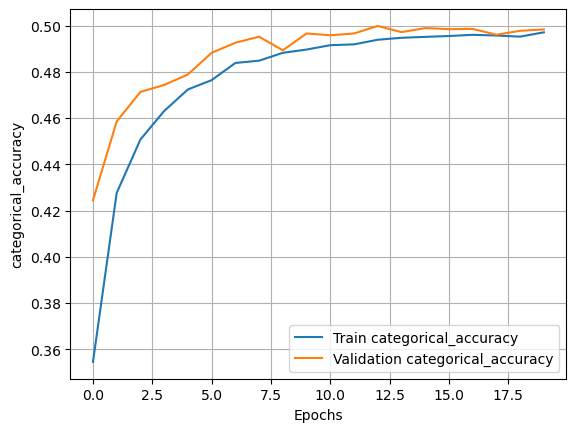

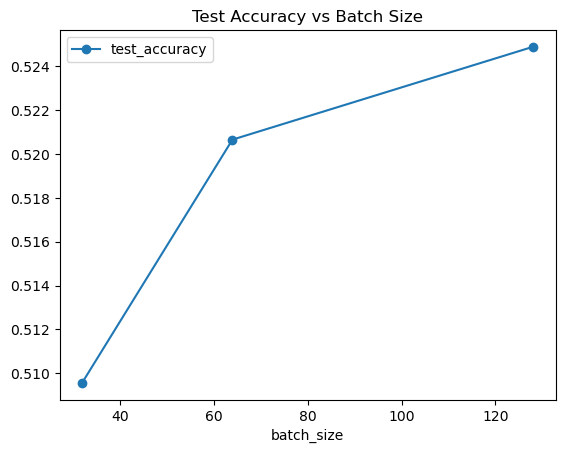

Max accuracy: 0.5248727798461914
Min accuracy: 0.5095692276954651
Standard deviation: 0.007902825585738594


In [9]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# Function to plot training history
def plot_performance(history, metric):
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.grid()
    plt.show()

# List to store results for different batch sizes
batch_sizes = [128, 64, 32]
accuracy_list = []
chunk_length = 30  # Sequence length
lstm_units = 256  # Fixed LSTM units for this test
learning_rate = 0.005  # Fixed learning rate for this test

# Iterate over batch sizes
for batch_size in batch_sizes:
    print(f"Testing with batch size: {batch_size}")

    # Load and preprocess data
    train_x, train_y, val_x, val_y, test_x, test_y = splitting_udf(
        text, chunk_length, step=3, train_perc=0.7, val_perc=0.15
    )

    # Build the model
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(chunk_length, len(chars)), 
                   dropout=0.2, recurrent_dropout=0.2))

    # Add the final Dense output layer
    model.add(Dense(len(chars), activation='softmax'))

    # Compile the model with gradient clipping
    optimizer = RMSprop(learning_rate=learning_rate, clipvalue=1.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

    # Train the model
    history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=20, batch_size=batch_size)

    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_x, test_y)
    print(f"Test Accuracy with batch size {batch_size}: {test_acc}")
    accuracy_list.append(test_acc)

    # Plot the performance
    plot_performance(history, "categorical_accuracy")

# Create a DataFrame to analyze results
import pandas as pd
accuracy_test_df = pd.DataFrame({
    "batch_size": batch_sizes,
    "test_accuracy": accuracy_list
})

# Plot the accuracy results
accuracy_test_df.plot(x="batch_size", y="test_accuracy", marker='o', title="Test Accuracy vs Batch Size")
plt.show()

# Print summary statistics
print(f"Max accuracy: {accuracy_test_df['test_accuracy'].max()}")
print(f"Min accuracy: {accuracy_test_df['test_accuracy'].min()}")
print(f"Standard deviation: {accuracy_test_df['test_accuracy'].std()}")


## Generalization Assessment

external text (unseen during training and validation) for the test set to assess generalization ability

In [10]:
### PREPROCESSING EXTERNAL TEXT

murubutu = "il_giovane_mariani.txt"

### READING FILE
print('opening file...')
with io.open(murubutu, encoding='utf-8') as f:
    murubutu_txt = f.read().lower()
    
print(murubutu_txt[:300])

opening file...
fu il primo gemito del primogenito
nato col primo freddo, il primo getto di freddo gelido
il giovane mariani apriva gli occhi
un raggio caldo creò un passaggio ampio fra due notti
fra due sfondi enormi vide un lampo e un'esplosione
poi un mondo con più occhi che le piume di pavone
prese aria e luce 


#### The Missing Chars Problem

Considering that the external text contains characters missing in the text used for the previous model training attempts we can face this problem with the following possible strategies:

- Removing missing characters from external text
    - This is of course the quick choiche in order to address this problem and shouldn't affect the experiment at all if the number of missing characters are very low compared to the overall vocabulary size
    
- Adding a single 'unknown character' placeholder

- Expannding the vocabulary
    - In this case we also have to re-train the model with the updated version of vocabulary

In [11]:
##### Exploring new characters of the external text:b

additional_chars = set(murubutu_txt) - set(chars)
print(additional_chars)
print(len(additional_chars))

# Count occurrences of each additional character
additional_char_counts = {char: murubutu_txt.count(char) for char in additional_chars}
print('Occurrences of additional characters:', additional_char_counts)

{'ù', 'ì', 'é', 'ò', 'è'}
5
Occurrences of additional characters: {'ù': 1, 'ì': 3, 'é': 4, 'ò': 11, 'è': 4}


### STRATEGY 1 Removing missing characters from external text

As it possible to observe in the cell above the number of occurences of missing charactes isn't huge so we can try a first attempt by applying the strategy 1 described previously.

In [12]:
#### STRATEGY 1 Removing missing characters from external text

cleaned_text = ''.join(c for c in murubutu_txt if c not in additional_chars)

print(cleaned_text[:300])

fu il primo gemito del primogenito
nato col primo freddo, il primo getto di freddo gelido
il giovane mariani apriva gli occhi
un raggio caldo cre un passaggio ampio fra due notti
fra due sfondi enormi vide un lampo e un'esplosione
poi un mondo con pi occhi che le piume di pavone
prese aria e luce e 


In [13]:
import numpy as np


def generate_sequences(text, maxlen, step):
    print(text[:50])
    sentences = []
    next_chars = []

    # iterate over the text 
    for i in range(0, len(text) - maxlen, step):

        # append chunks of lenght maxlen: ABC, DEF,GHI ...  ---> INPUT
        sentences.append(text[i: i + maxlen])

        # append the next chunk of the lenght: D, G, ...    ---> LABEL 
        next_chars.append(text[i + maxlen])
        
        if i == 0:
            print("sentence: ", text[i: i + maxlen])
            print("next_chars: ", text[i + maxlen])
    return sentences, next_chars
    

# Convert to one-hot encoded arrays (as describe above)
def vectorize(sentences, next_chars, char_indices, maxlen, num_chars):
    x = np.zeros((len(sentences), maxlen, num_chars), dtype=bool)
    y = np.zeros((len(sentences), num_chars), dtype=bool)
    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1
    return x, y

ext_sentences, ext_next_chars = generate_sequences(cleaned_text, maxlen, step)
ext_test_x, ext_test_y = vectorize(ext_sentences, ext_next_chars, char_indices, maxlen, len(chars))



fu il primo gemito del primogenito
nato col primo 
sentence:  fu il primo gemito del primoge
next_chars:  n


### External Text Test Strategy 1 Results:

The first thing we can note on these results is that the accuracy score against the external test is significantly (0.37) lower as compared to the tests against an extraction of the same initial text (0.50 - 0.52).

In this test case the external text was preprocessed by removing the additional characters not present in the training set. These missing characters accounted for only 20 occurrences out of 2,600 characters (~0.77% of the text).

Since the additional characters were a very small fraction of the total text and were removed, their influence on the accuracy drop is negligible. The reduced performance is more likely attributed to differences in the structure, style, or distribution of the external text rather than the removed characters.

The lower accuracy indicates that the external text contains linguistic or structural patterns (e.g., sequences, syntax, or semantics) unfamiliar to the model. This highlights a distributional shift between the training data and the external text, which the RNN struggles to handle.

In [15]:
# Evaluate the model
test_loss, test_acc = model.evaluate(ext_test_x, ext_test_y, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


Test Loss: 2.2399816513061523
Test Accuracy: 0.3717647194862366


### STRATEGY 3: EXPANDING VOCABULARY and RE-TRAINING THE MODEL

In [18]:
#### STRATEGY 3 - EXPANDING VOCABULARY: --> need model retraining

# Update the vocabulary to include characters from the external text
additional_chars = set(murubutu_txt) - set(chars)

# expanding vocabulary and re-initialize global variables
init_work_env(additional_chars)





opening file...
text length: 558240






 ****** first 1000 characters ******* 




total chars:  40
Extending vocabulary
extendend total chars:  45
{'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, ':': 10, ';': 11, '<': 12, '>': 13, '?': 14, '`': 15, 'a': 16, 'b': 17, 'c': 18, 'd': 19, 'e': 20, 'f': 21, 'g': 22, 'h': 23, 'i': 24, 'j': 25, 'l': 26, 'm': 27, 'n': 28, 'o': 29, 'p': 30, 'q': 31, 'r': 32, 's': 33, 't': 34, 'u': 35, 'v': 36, 'x': 37, 'y': 38, 'z': 39, 'è': 40, 'é': 41, 'ì': 42, 'ò': 43, 'ù': 44}
{0: '\n', 1: ' ', 2: '!', 3: '"', 4: "'", 5: '(', 6: ')', 7: ',', 8: '-', 9: '.', 10: ':', 11: ';', 12: '<', 13: '>', 14: '?', 15: '`', 16: 'a', 17: 'b', 18: 'c', 19: 'd', 20: 'e', 21: 'f', 22: 'g', 23: 'h', 24: 'i', 25: 'j', 26: 'l', 27: 'm', 28: 'n', 29: 'o', 30: 'p', 31: 'q', 32: 'r', 33: 's', 34: 't', 35: 'u', 36: 'v', 37: 'x', 38: 'y', 39: 'z', 40: 'è', 41: 'é', 42: 'ì', 43: 'ò', 44: 'ù'}
number of sequences:  186070
 mezzo del cammin di nostra

Testing with 1 LSTM layers
Epoch 1/20
1018/1018 [==============================] - 264s 252ms/step - loss: 2.5172 - categorical_accuracy: 0.2647 - val_loss: 2.1326 - val_categorical_accuracy: 0.3333
Epoch 2/20
1018/1018 [==============================] - 268s 263ms/step - loss: 2.1588 - categorical_accuracy: 0.3333 - val_loss: 1.9651 - val_categorical_accuracy: 0.3722
Epoch 3/20
1018/1018 [==============================] - 272s 267ms/step - loss: 2.0299 - categorical_accuracy: 0.3638 - val_loss: 1.8755 - val_categorical_accuracy: 0.3997
Epoch 4/20
1018/1018 [==============================] - 273s 268ms/step - loss: 1.9476 - categorical_accuracy: 0.3844 - val_loss: 1.8355 - val_categorical_accuracy: 0.4091
Epoch 5/20
1018/1018 [==============================] - 279s 275ms/step - loss: 1.8808 - categorical_accuracy: 0.4032 - val_loss: 1.7746 - val_categorical_accuracy: 0.4336
Epoch 6/20
1018/1018 [==============================] - 292s 287ms/step - loss: 1.8277 - categorical_accuracy: 0.

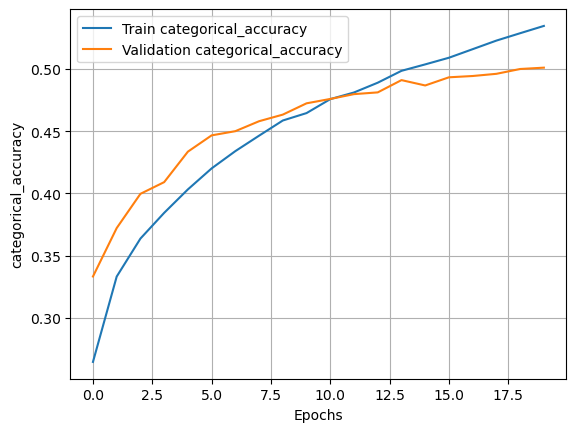

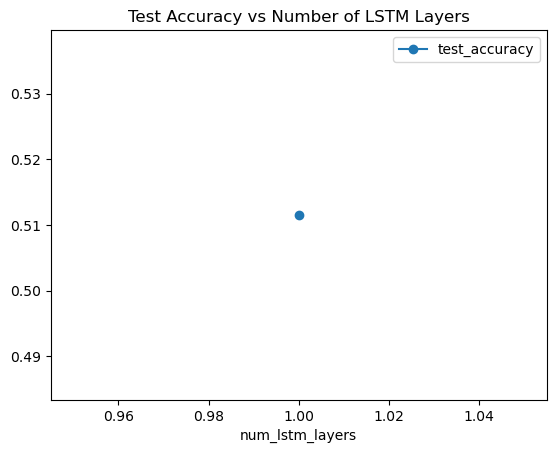

Max accuracy: 0.511540412902832
Min accuracy: 0.511540412902832
Standard deviation: nan


In [19]:
#### RE-TRAINING THE MODEL

# List to store results for the number of LSTM layers
num_lstm_layers_list = []
accuracy_list = []
chunk_length = 30  # Sequence length

# Iterate over 1 to 2 LSTM layers --> Set this time only 1 LSTM layer
for num_lstm_layers in range(1, 2):
    print(f"Testing with {num_lstm_layers} LSTM layers")
    num_lstm_layers_list.append(num_lstm_layers)

    # Load and preprocess data
    train_x, train_y, val_x, val_y, test_x, test_y = splitting_udf(text, chunk_length, step=3, train_perc=0.7, val_perc=0.15)

    # Build the model
    model = Sequential()
    for layer_idx in range(num_lstm_layers):
        return_sequences = layer_idx < num_lstm_layers - 1  # Return sequences for all but the last layer
        if layer_idx == 0:
            # First layer requires input shape
            model.add(LSTM(512, return_sequences=return_sequences, input_shape=(chunk_length, len(chars)), 
                           dropout=0.2, recurrent_dropout=0.2))
        else:
            # Subsequent layers infer input shape
            model.add(LSTM(256, return_sequences=return_sequences, 
                           dropout=0.2, recurrent_dropout=0.2))

    # Add the final Dense output layer
    model.add(Dense(len(chars), activation='softmax'))

    # Compile the model with gradient clipping
    optimizer = RMSprop(learning_rate=0.001, clipvalue=1.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

    # Train the model
    history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=20, batch_size=128)

    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_x, test_y)
    print(f"Test Accuracy with {num_lstm_layers} LSTM layers: {test_acc}")
    accuracy_list.append(test_acc)

    # Plot the performance
    plot_performance(history, "categorical_accuracy")

# Create a DataFrame to analyze results
import pandas as pd
accuracy_test_df = pd.DataFrame({
    "num_lstm_layers": num_lstm_layers_list,
    "test_accuracy": accuracy_list
})

# Plot the accuracy results
accuracy_test_df.plot(x="num_lstm_layers", y="test_accuracy", marker='o', title="Test Accuracy vs Number of LSTM Layers")
plt.show()

# Print summary statistics
print(f"Max accuracy: {accuracy_test_df['test_accuracy'].max()}")
print(f"Min accuracy: {accuracy_test_df['test_accuracy'].min()}")
print(f"Standard deviation: {accuracy_test_df['test_accuracy'].std()}")


### External Text Test Strategy 3 Results:

This last test only confirms what we have said in the previous one and furthemore confirm that removing missing chars does'n really affect the overall performance against the external text that remains low (0.33 accuracy score).

In [21]:
# Creating sequences with the orginal external text (no characters removing)

ext_sentences, ext_next_chars = generate_sequences(murubutu_txt, maxlen, step)
ext_test_x, ext_test_y = vectorize(ext_sentences, ext_next_chars, char_indices, maxlen, len(chars))

# Evaluating the model against the external text
test_loss, test_acc = model.evaluate(ext_test_x, ext_test_y, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

fu il primo gemito del primogenito
nato col primo 
sentence:  fu il primo gemito del primoge
next_chars:  n
Test Loss: 2.4301950931549072
Test Accuracy: 0.32983681559562683


# Considerations and Conclusions Summary:

- The fine tunining of chunk lenght have been shown that the best performance is associated to lenght 30, by the way the overall deviation between all the experiment it's really low, this leads to the conclusion that for this task and a simple architecture considering only the lenght of the chunks is reductive.

- Adding more LSTM layers does not improve model's performance, on the contrary it make it worse if the number of layers is greater than 3

- Regularization techniques don't seem to have a huge impact on the test performance rather they seems to avoid divergence between training and validation accuracy (without leading to a really better score on unseen data)

- Increasing the number of dense layer of the Architecture doesn't help

- A slight improvement has been reached by focusing on specific hyperparamters rathern than architecture's layers

- In particular, fine-tunining the batch size has been resulted to be the best approach (among all those tried) to improve the model's performance, however we have to consider that also in this best case we got a poor accuracy level (0.52) less more than tossing a coin.

- Testing the generalization ability against an external test with a different style has shown that the model underperform against new structural and syntax patterns (accuracy scores of 0.37 - 0.33)